In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import tqdm
import pickle
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

### Gaussian noise

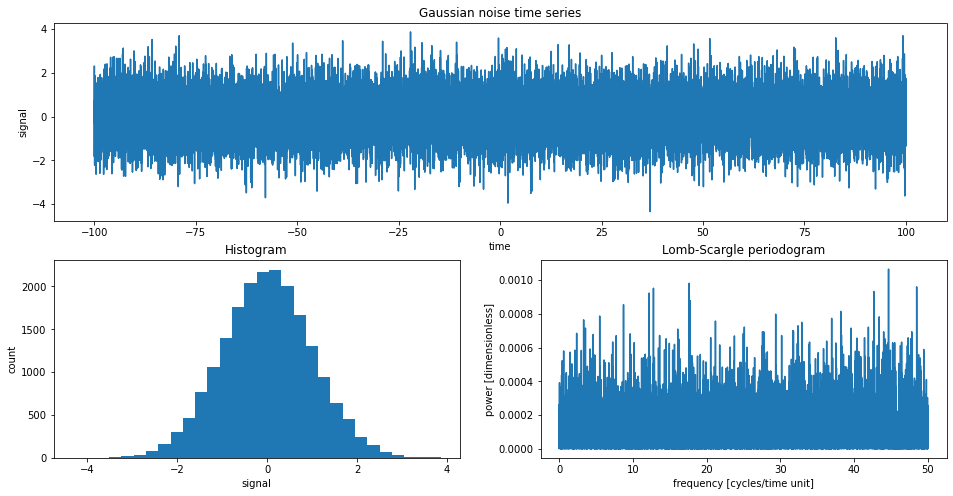

In [2]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise = np.random.normal(0.,1.,len(t))
sp.plotTimeSeries(t, gaussianNoise,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Gaussian noise")

### Multiperiodic signals

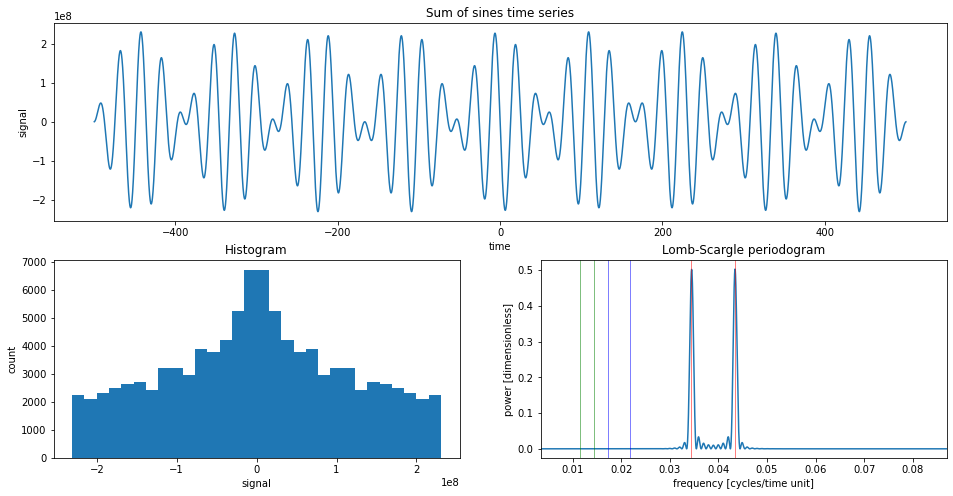

In [3]:
dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

v1 = 2*np.pi*(1./23.)
v2 = 2*np.pi*(1./29.)

trueFreqs = np.array((1./23.,1./29.))

simplePeriodic = (np.sin(t*v1) + np.sin(t*v2))
simplePeriodic = simplePeriodic/np.mean(simplePeriodic)
sp.plotTimeSeries(t, simplePeriodic,min_freq=(1./baseline),max_freq=(1./(2.*dt)), nq=10, spp=100, 
               LS_xlim = (0.1*np.min(trueFreqs),2*np.max(trueFreqs)), plot_harmonics=True, 
               true_freq=trueFreqs,title="Sum of sines")

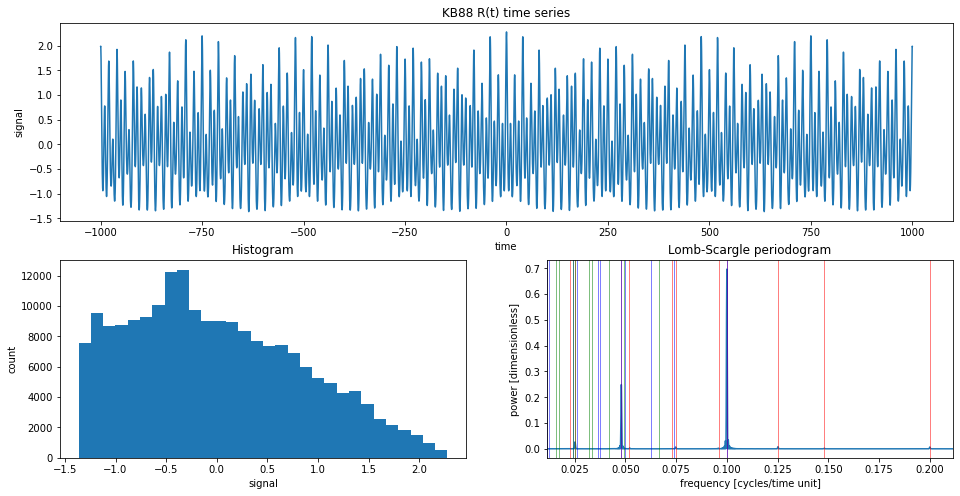

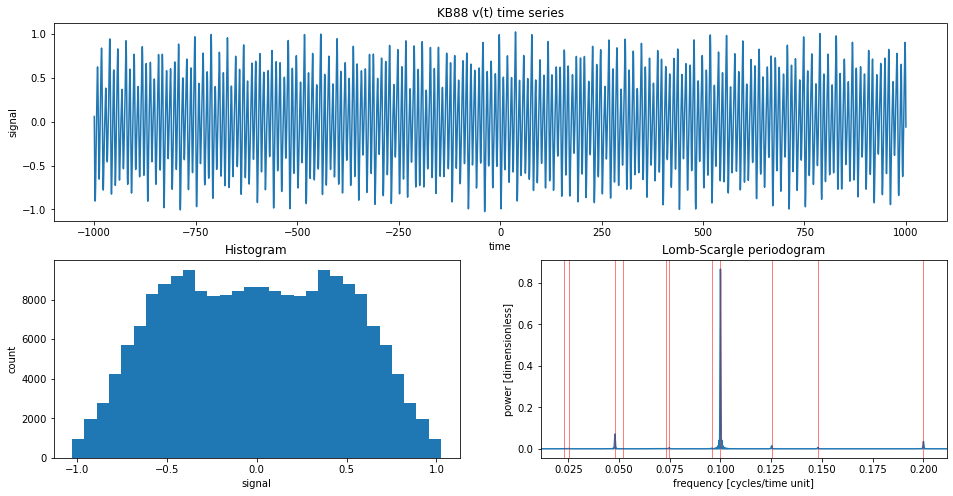

In [4]:
# multi-periodic signal from Kovacs & Buchler 1988
dt = 0.01
tmin = -1000.
tmax = 1000.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

multiPeriodic_r, multiPeriodic_v = sp.KB88(t)

trueFreqs = np.array((0.1, 0.048, 0.0252, 0.1+0.048, 0.1-0.048, 0.048+0.0252, 0.048-0.0252, 0.1+0.0252, 0.1-0.0252, 2*0.1, 2*0.048,))

sp.plotTimeSeries(t, multiPeriodic_r, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, plot_harmonics=True, title="KB88 R(t)")
sp.plotTimeSeries(t, multiPeriodic_v, min_freq=0.5*np.min(trueFreqs),max_freq=np.max(trueFreqs)+0.5*np.min(trueFreqs), nq=10, spp=100, 
               LS_xlim = (0.5*np.min(trueFreqs),np.max(trueFreqs)+0.5*np.min(trueFreqs)), true_freq=trueFreqs, title="KB88 v(t)")

### Rossler system 

In [5]:
fp1, fp2 = sp.Rossler_FPs(a=0.2,b=0.2,c=4.8)
print(fp1)
print(fp2)

[  4.79165215 -23.95826074  23.95826074]
[ 0.00834785 -0.04173926  0.04173926]


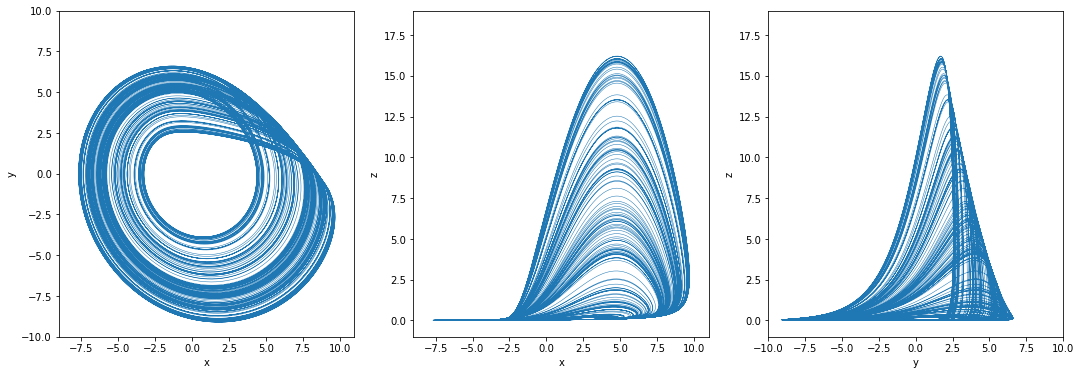

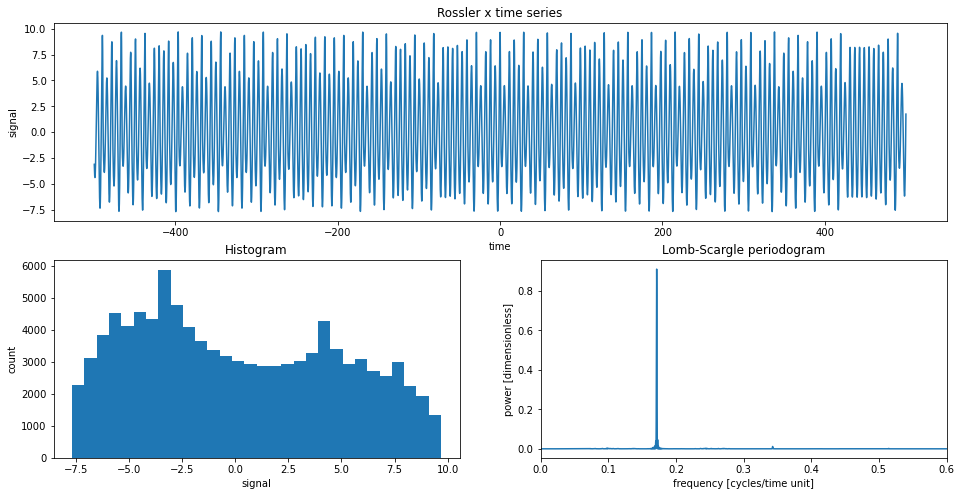

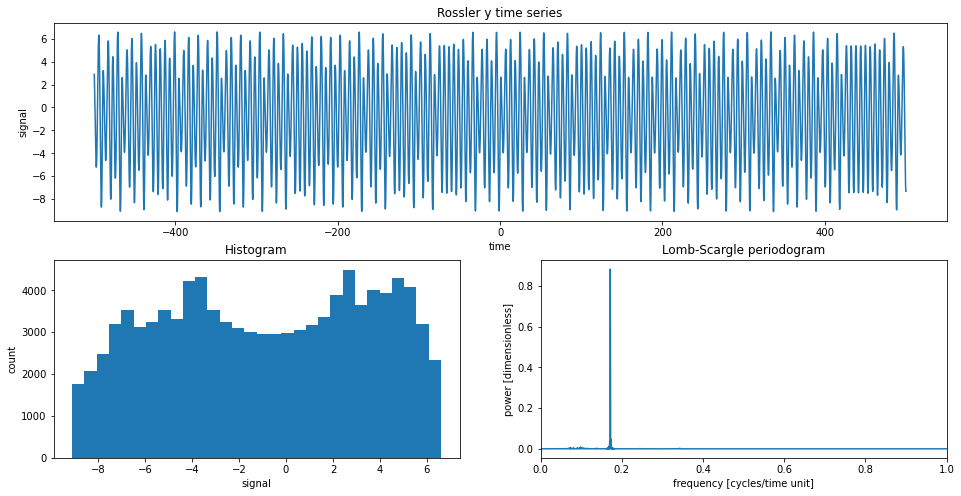

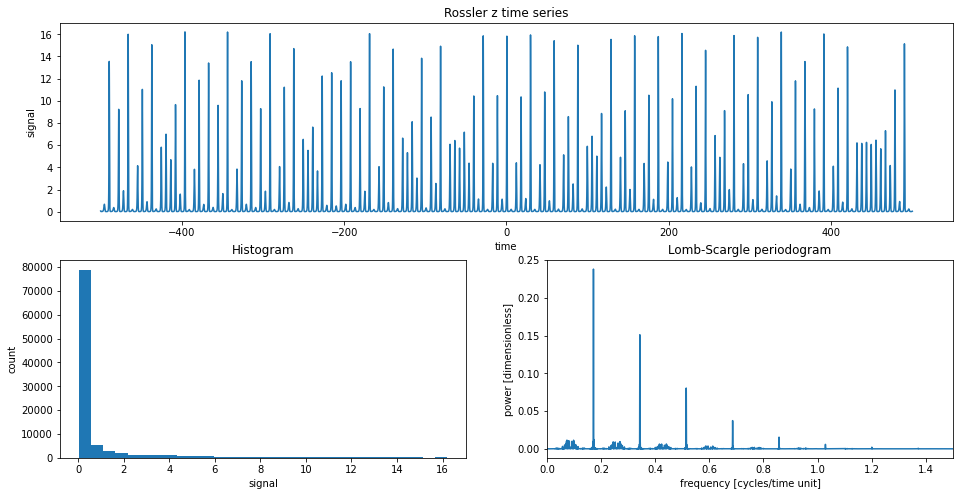

In [6]:
#r0 = np.array((0.1, -7, 0.1))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-3.07896671,  2.91997852,  0.07254192))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 4.79165215
fp1_y = -23.95826074
fp1_z = 23.95826074
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.00834785
fp2_y = -0.04173926
fp2_z = 0.04173926
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((Nsteps,3))
rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y

#print(rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rossler_r[:,0],rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-9,11)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rossler_r[:,0],rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-9,11)
axes[1].set_ylim(-1,19)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rossler_r[:,1],rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-10,10)
axes[2].set_ylim(-1,19)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rossler_t,rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,0.6),title="Rossler x")
sp.plotTimeSeries(rossler_t,rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.),title="Rossler y")
sp.plotTimeSeries(rossler_t,rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,1.5),title="Rossler z")

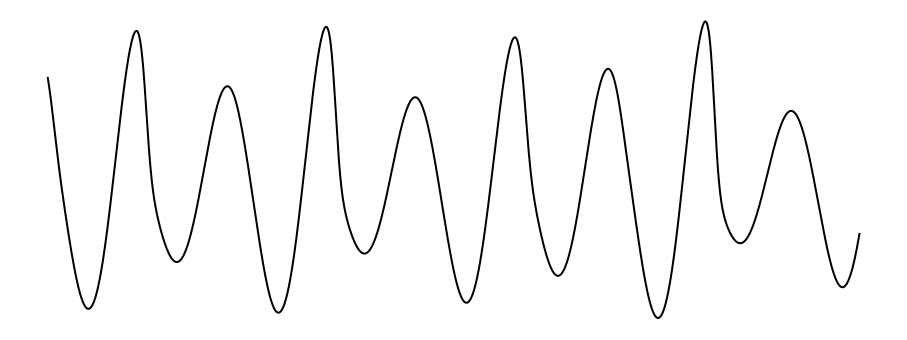

In [7]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t[-15000:-10000],rossler_r[-15000:-10000,0],'k-',lw=2)
ax.axis("off")
plt.savefig("./rossler_x_forposter.pdf")


### Rotated Rossler system (inspired by Letellier & Aguirre 2002)

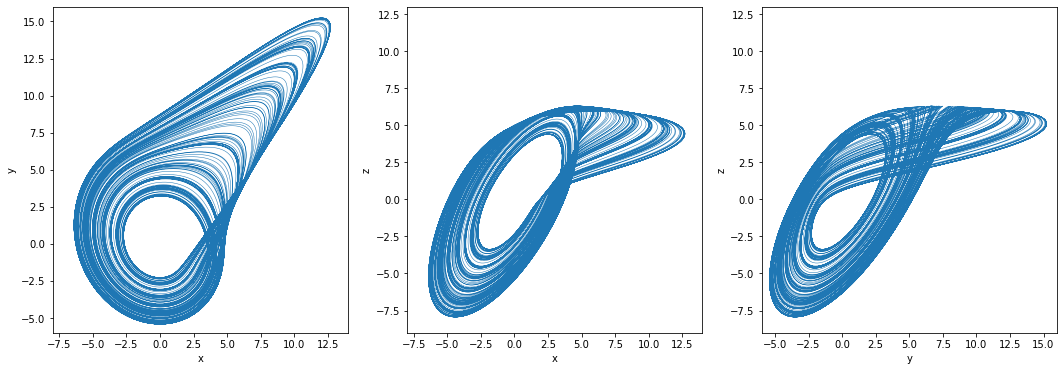

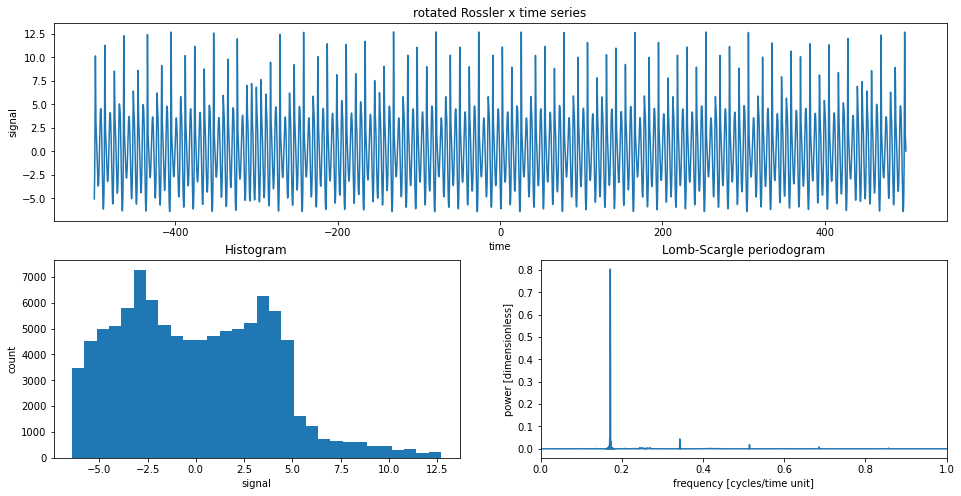

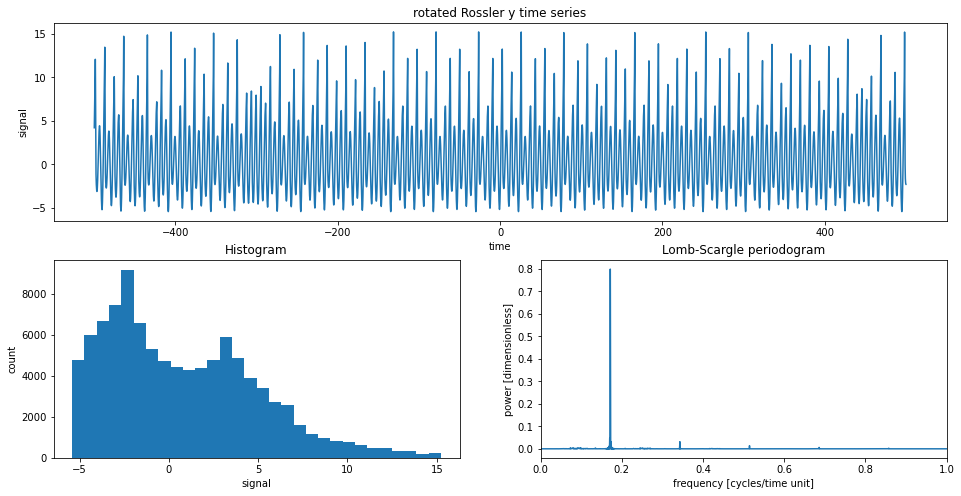

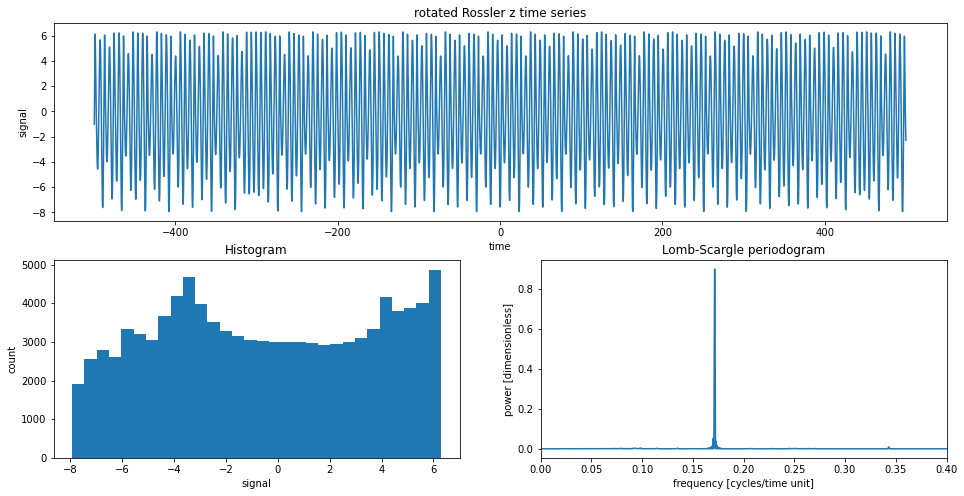

In [8]:
#r0 = (1./np.sqrt(2))*np.array((2.9+0.07, 0.07-3.08, -3.08+2.9))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
r0 = np.array((-5.09005781,4.17054396,-1.09101873))
# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 4.79165215
fp1_y = -23.95826074
fp1_z = 23.95826074
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.00834785
fp2_y = -0.04173926
fp2_z = 0.04173926
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))



dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rotated_rossler = RK45(fun=sp.rotated_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rotated_rossler_r = np.empty((Nsteps,3))
rotated_rossler_t = np.empty((Nsteps))
for i in range(Nsteps):
    rotated_rossler.step()
    rotated_rossler_t[i] = rotated_rossler.t
    rotated_rossler_r[i] = rotated_rossler.y
    #print(i, rotated_rossler_r[i])
#print(rotated_rossler_r[5000])

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,1],lw=0.5)
axes[0].set_xlim(-8,14)
axes[0].set_ylim(-6,16)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(rotated_rossler_r[:,0],rotated_rossler_r[:,2],lw=0.5)
axes[1].set_xlim(-8,14)
axes[1].set_ylim(-9,13)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(rotated_rossler_r[:,1],rotated_rossler_r[:,2],lw=0.5)
axes[2].set_xlim(-6,16)
axes[2].set_ylim(-9,13)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler x")
sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,1.),title="rotated Rossler y")
sp.plotTimeSeries(rotated_rossler_t,rotated_rossler_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)), LS_xlim=(0.,0.4),title="rotated Rossler z")

### Lorenz system

In [9]:
fp1, fp2 = sp.Lorenz_FPs(sigma=10., beta=8./3., rho=28.)
print(fp1)
print(fp2)

unstable
[ 8.48528137  8.48528137 27.        ]
[-8.48528137 -8.48528137 27.        ]


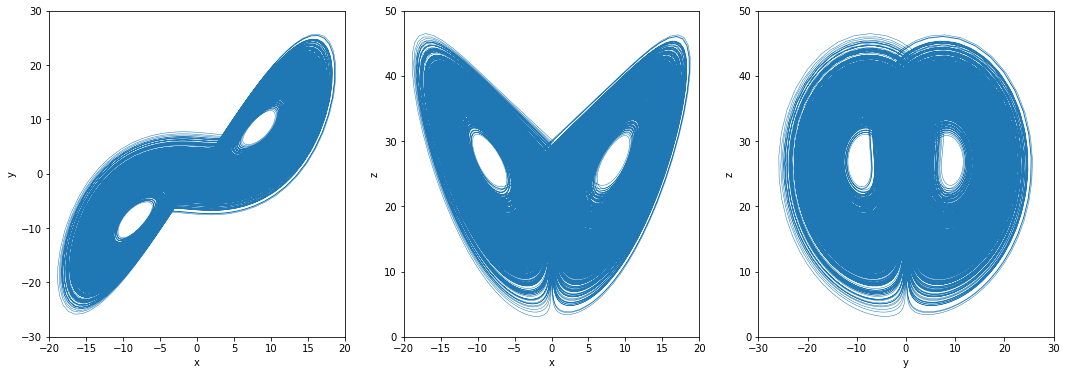

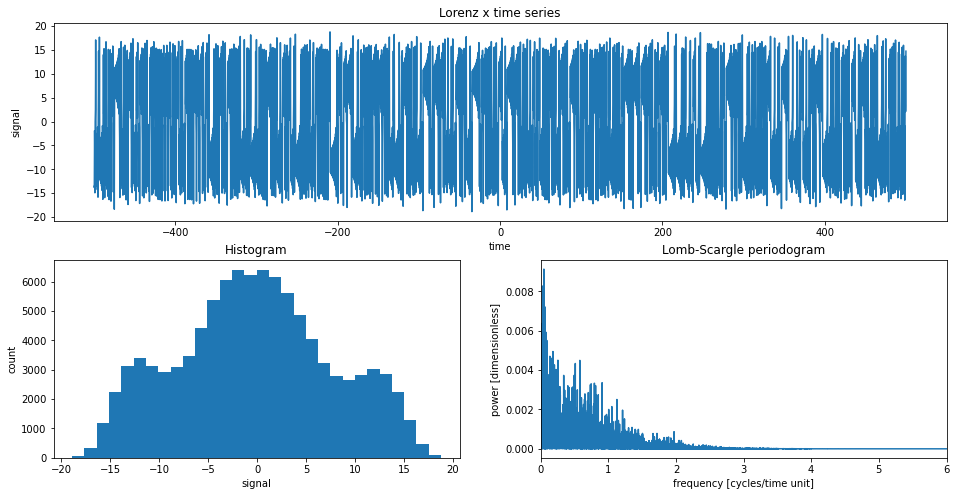

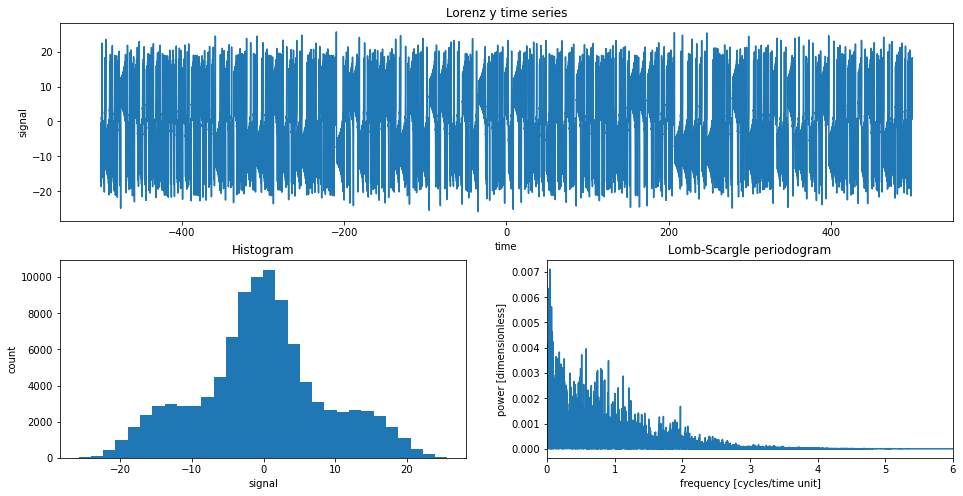

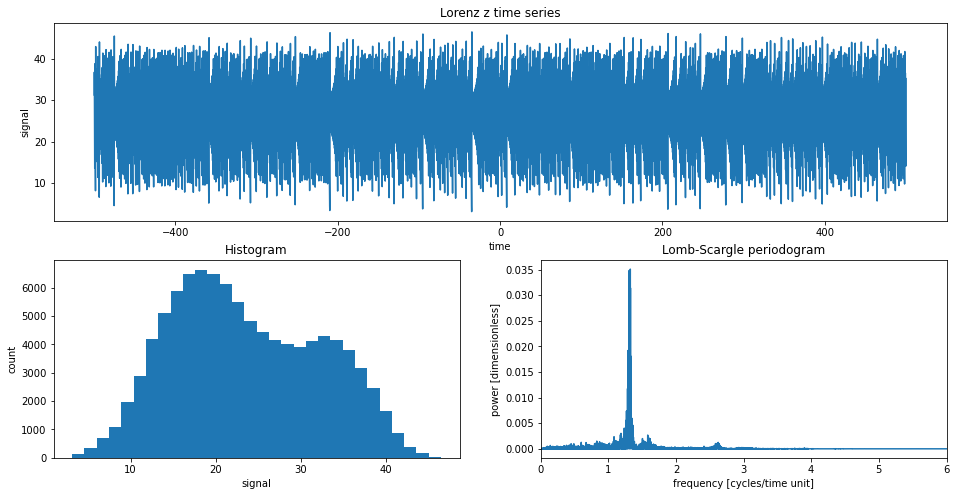

In [10]:
#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))


#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((Nsteps,3))
lorenz_t = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y


fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

sp.plotTimeSeries(lorenz_t,lorenz_r[:,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,1],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz y")
sp.plotTimeSeries(lorenz_t,lorenz_r[:,2],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz z")

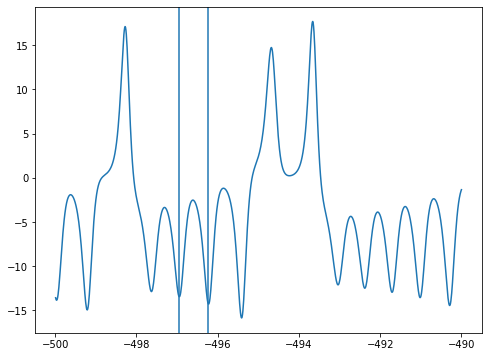

71.99999999999704


In [225]:
#sp.plotTimeSeries(lorenz_t[:1000],lorenz_r[:1000,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
#sp.plotTimeSeries(lorenz_t[:5000],lorenz_r[:5000,0],min_freq=(1./baseline),max_freq=(1./(2.*dt)),LS_xlim=(0.,6.),title="Lorenz x")
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(lorenz_t[:1000],lorenz_r[:1000,0])
ax.axvline(-496.95)
ax.axvline(-496.23)
plt.show()
#print(len(lorenz_r[:1000,0][lorenz_r[:1000,0] > 0.]))
#print(len(lorenz_r[:5000,0][lorenz_r[:5000,0] > 0.]))

print((-496.23+496.95)/0.01)

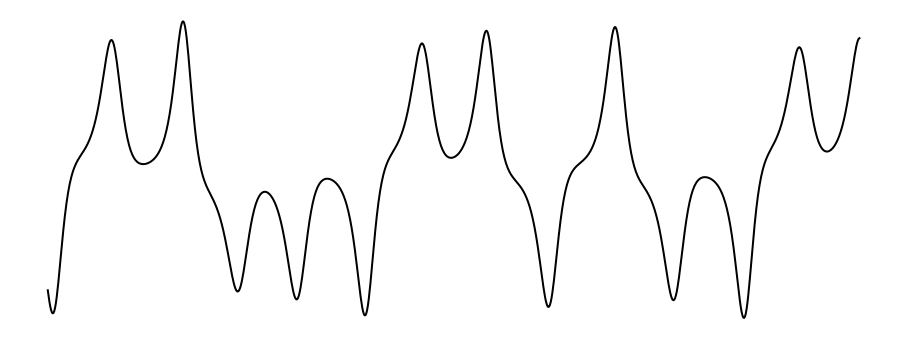

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t[-1000:],lorenz_r[-1000:,0],'k-',lw=2)
ax.axis("off")
plt.savefig("./lorenz_x_forposter.pdf")


## Number of data points 

In [13]:
print(np.shape(rossler_t))
print(np.shape(rossler_r))

(100000,)
(100000, 3)


In [14]:
print(np.shape(rotated_rossler_t))
print(np.shape(rotated_rossler_r))

(100000,)
(100000, 3)


In [15]:
print(np.shape(lorenz_t))
print(np.shape(lorenz_r))

(100000,)
(100000, 3)


# Choose time delay

### Fraser & Swinney 1986 (used 32,768 points for the Belousov-Zhabotinskii rxn; 1,048,576 points for the Rossler system)

### note: keep track of time taken per choice of delay time

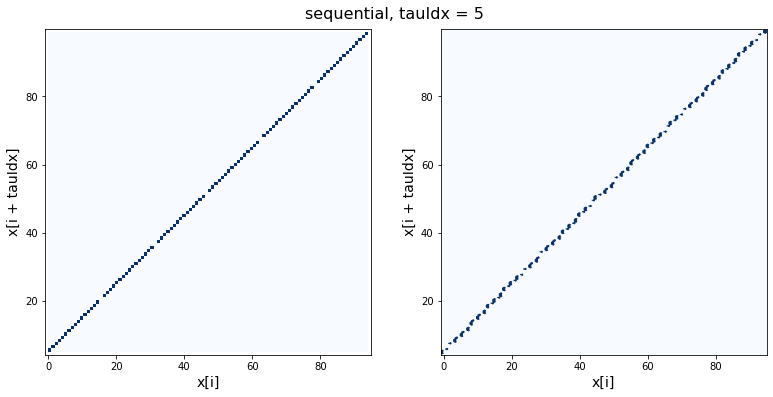

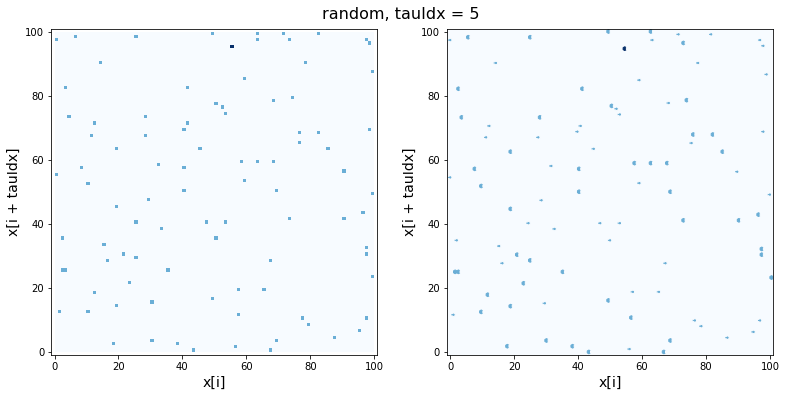

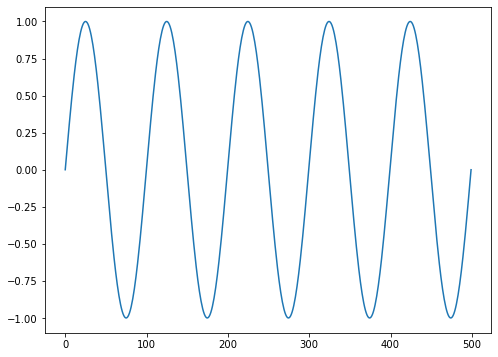

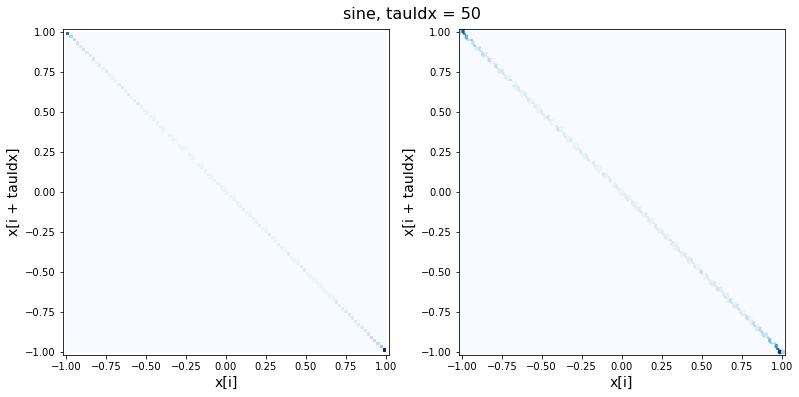

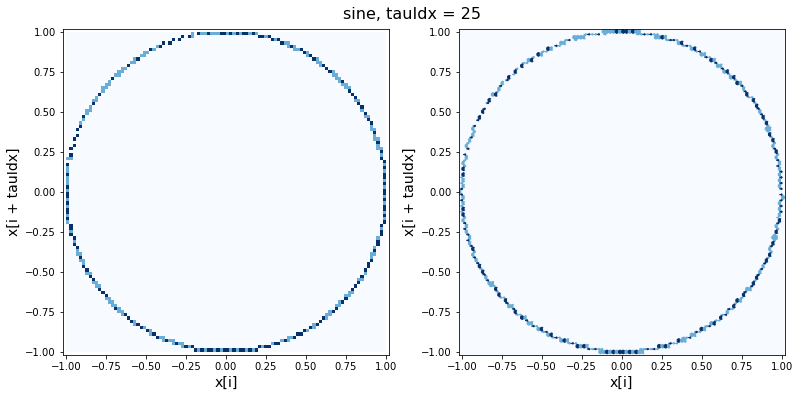

In [14]:
# test cases:
# sequential array
sp.bin2D(timeSeries=np.arange(100),tauIdx=5,plotTitle="sequential, tauIdx = 5")
# random array
sp.bin2D(timeSeries=np.random.randint(0,101,100),tauIdx=5,plotTitle="random, tauIdx = 5")
# correlated array
corr_arr = np.sin(np.linspace(0.,10.*np.pi,500))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(corr_arr)
plt.show()
sp.bin2D(timeSeries=corr_arr, tauIdx = 50, plotTitle="sine, tauIdx = 50") # non-optimal! 
sp.bin2D(timeSeries=corr_arr, tauIdx = 25, plotTitle="sine, tauIdx = 25") # optimal! 50*n = perfect linear correlation

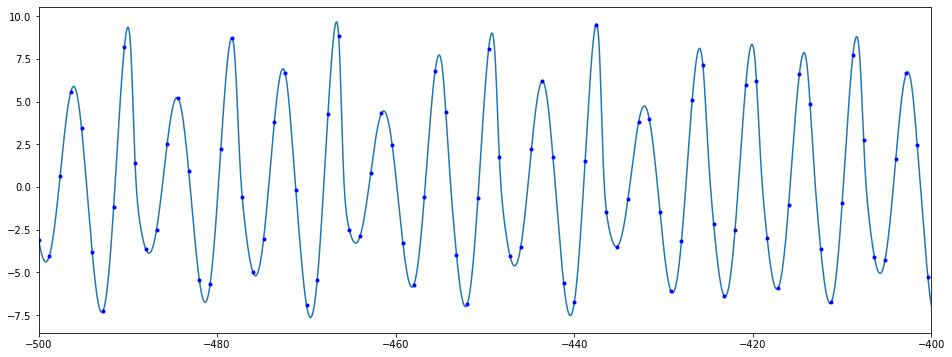

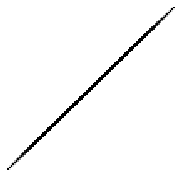

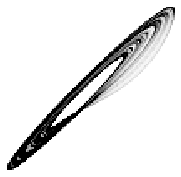

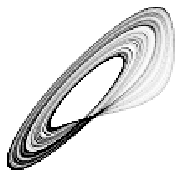

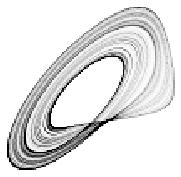

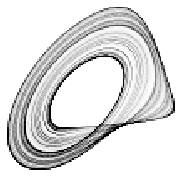

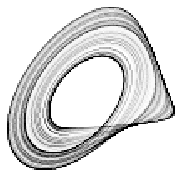

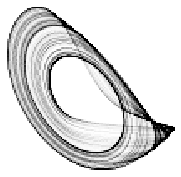

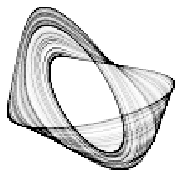

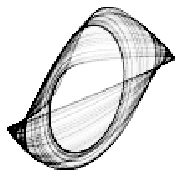

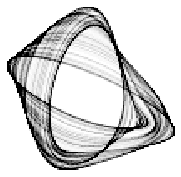

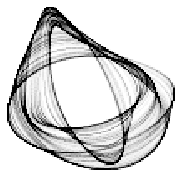

In [46]:
# rossler
testDelayIdxs = np.array((1,20,50,75,100,109,200,400,500,750,1000))
#testDelayIdxs = np.arange(1,201,10)
#testDelayIdxs = np.arange(110,130,10)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(rossler_t,rossler_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 120
ax.plot(rossler_t[::delay],rossler_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()

vmaxs = np.array((120,70,60,60,50,50,50,50,50,40,40))
for i, t in enumerate(testDelayIdxs):
    #sp.bin2D(timeSeries=rossler_r[:,0], tauIdx = i, plotTitle="tauIdx = {0}".format(i))
    x = rossler_r[:,0][:-t]
    y = rossler_r[:,0][t:]
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.hist2d(x,y,bins=(100,100),cmap="Greys",vmin=0,vmax=vmaxs[i])
    ax.axis("off")
    plt.savefig("./rossler_x_forposter_tauIdx={0}.pdf".format(t))
    #plt.show()
#this is SO COOL
# so just by eye it looks like the first minimum of the mutual information should fall around tau~120 for the Rossler x 
# time series.

In [28]:
MI = np.zeros((500))

start = time.time()
for i in range(500):
    MI[i] = sp.calc_MI(lorenz_r[:-(i+1),0], lorenz_r[(i+1):,0],Xbins=sp.optimal_Nbins(lorenz_r[:-(i+1),0]), Ybins = sp.optimal_Nbins(lorenz_r[(i+1):,0]))
end = time.time()
print((end - start)/500.)

0.019697216033935545


In [213]:
#expectation of first minimum, based on FS86
firstMin = ((193.3*(np.pi/100.)) * 0.23) * 100
print(firstMin)

139.67206778594863


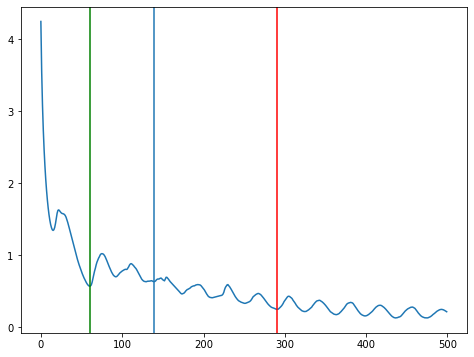

290


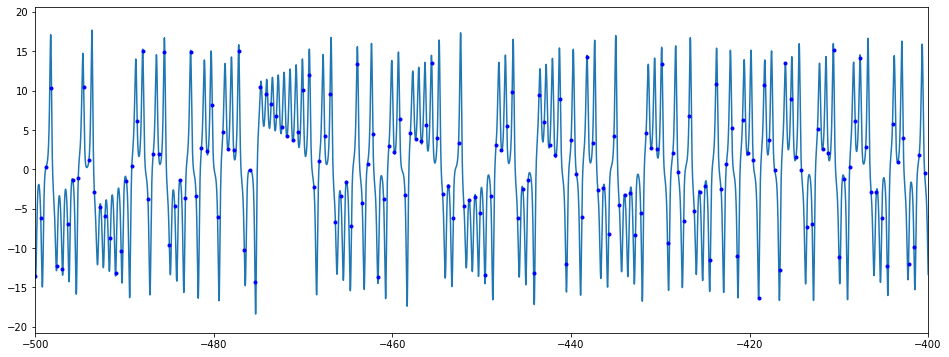

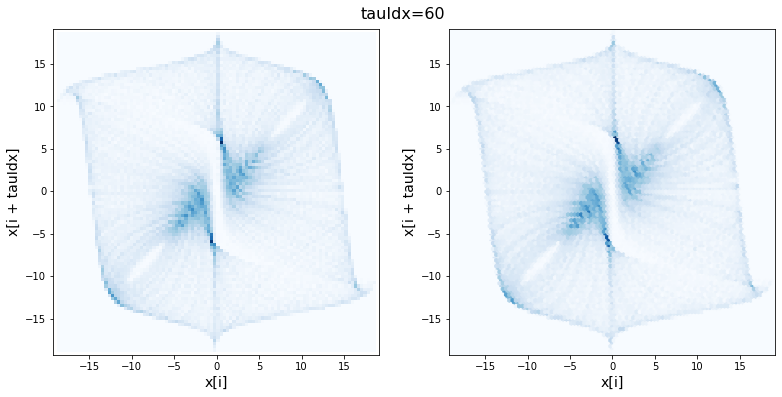

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(MI)
ax.axvline(firstMin)
ax.axvline(np.argmin(MI[0:300]),color='r')
ax.axvline(45+15,color='g')
plt.show()
print(np.argmin(MI[0:300]))

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(lorenz_t,lorenz_r[:,0])
#for i in testDelayIdxs:
#    ax.axvline(rossler_t[i],color='k')

# see where the nice-looking delays happen along the time series. remember: what makes a good delay is *minimal* correlation,
# not maximal! so the delay should not correspond to an inherent periodicity of the system.
delay = 60 #np.argmin(MI[0:300])
ax.plot(lorenz_t[::delay],lorenz_r[::delay,0,],'b.')
ax.set_xlim(-500,-400)
plt.show()
sp.bin2D(timeSeries=lorenz_r[:,0], tauIdx = 60, plotTitle="tauIdx=60")#plotTitle="tauIdx = {0}".format(np.argmin(MI[0:300])))

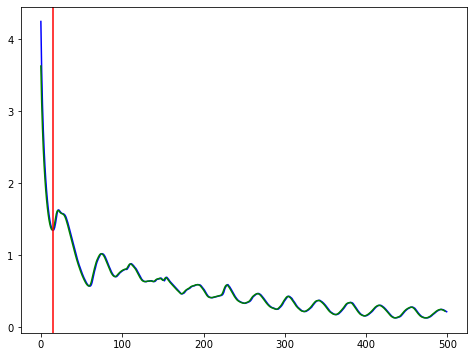

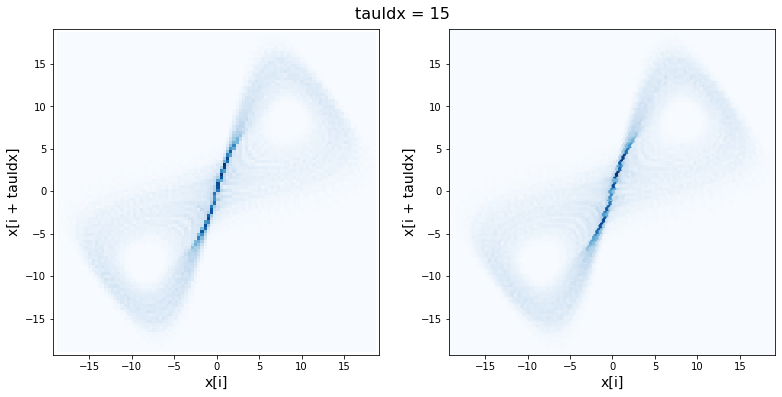

In [226]:
mutInfo, bestTau = sp.FS86(timeSeries = lorenz_r[:,0], trialDelayIndices = np.arange(0,500), plot=True)

# Choose embedding dimension

### Cao 1997

### Rossler

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


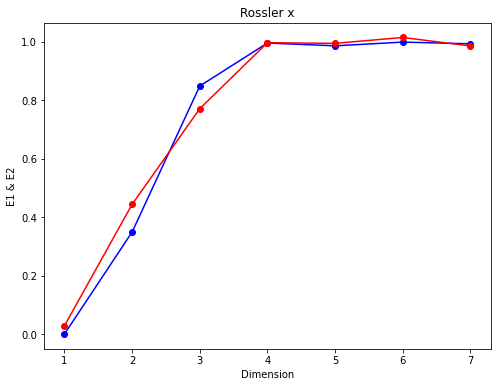

In [227]:
E1, E2 = sp.cao97(timeSeries = rossler_r[:5000,0], tau = 109, mMax = 8)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rossler x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rossler_x.png")

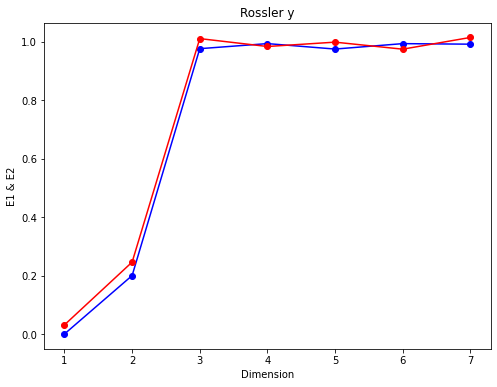

In [24]:
E1, E2 = sp.cao97(timeSeries = rossler_r[:5000,1], tau = 149, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rossler y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rossler_y.png")

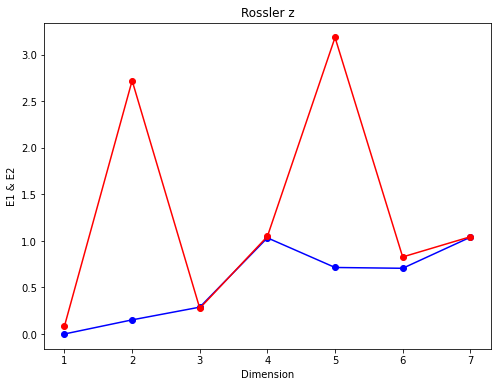

In [25]:
E1, E2 = sp.cao97(timeSeries = rossler_r[:5000,2], tau = 183, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rossler z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rossler_z.png")

### Rotated Rossler

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


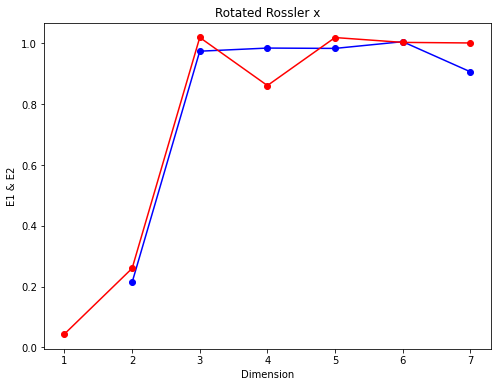

In [27]:
E1, E2 = sp.cao97(timeSeries = rotated_rossler_r[:5000,0], tau = 138, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rotated Rossler x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rotated_rossler_x.png")

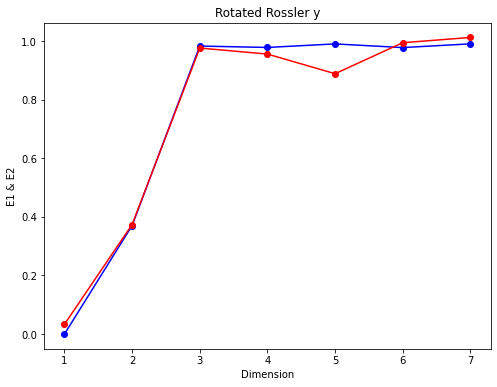

In [28]:
E1, E2 = sp.cao97(timeSeries = rotated_rossler_r[:5000,1], tau = 134, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rotated Rossler y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rotated_rossler_y.png")

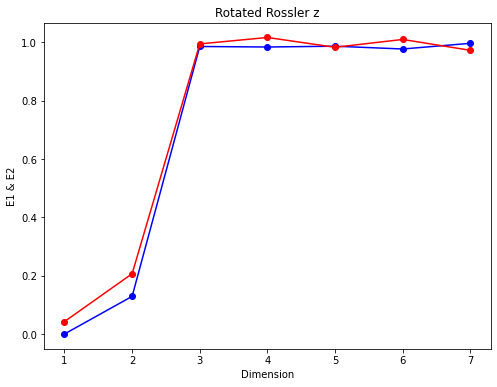

In [29]:
E1, E2 = sp.cao97(timeSeries = rotated_rossler_r[:5000,2], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Rotated Rossler z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/rotated_rossler_z.png")

### Lorenz

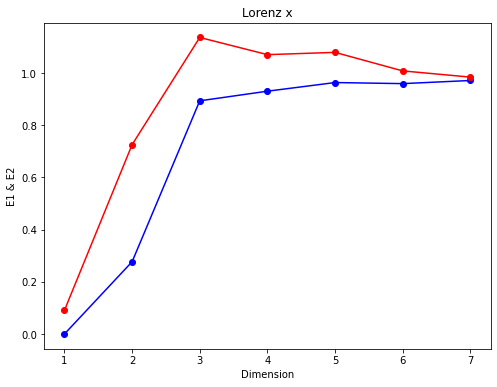

In [30]:
E1, E2 = sp.cao97(timeSeries = lorenz_r[:5000,0], tau = 15, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Lorenz x')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/lorenz_x.png")

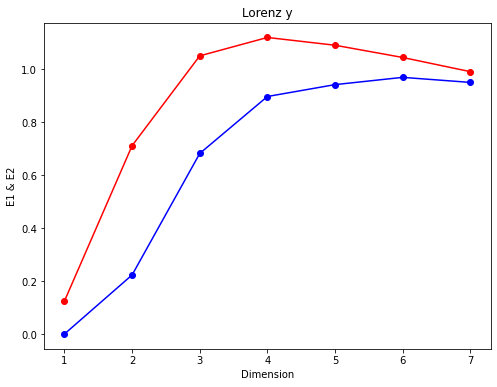

In [31]:
E1, E2 = sp.cao97(timeSeries = lorenz_r[:5000,1], tau = 14, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Lorenz y')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/lorenz_y.png")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


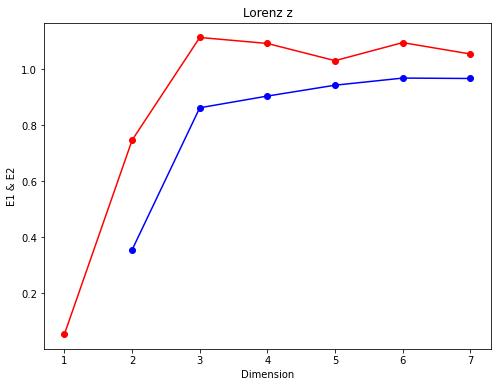

In [32]:
E1, E2 = sp.cao97(timeSeries = lorenz_r[:5000,2], tau = 15, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Lorenz z')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/lorenz_z.png")

### Gaussian noise

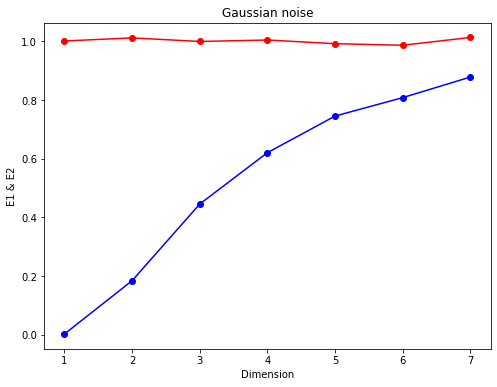

In [33]:
E1, E2 = sp.cao97(timeSeries = gaussianNoise[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Gaussian noise')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/gaussian_noise.png")

### Simple periodic

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


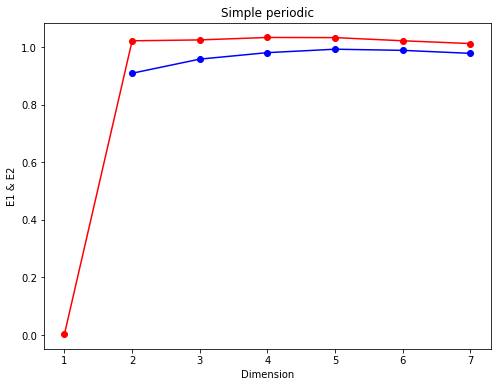

In [34]:
E1, E2 = sp.cao97(timeSeries = simplePeriodic[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Simple periodic')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/simple_periodic.png")

### Kovacs & Buchler 1988

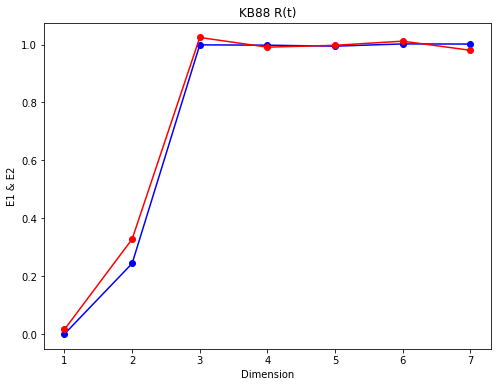

In [35]:
E1, E2 = sp.cao97(timeSeries = multiPeriodic_r[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('KB88 R(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_r.png")

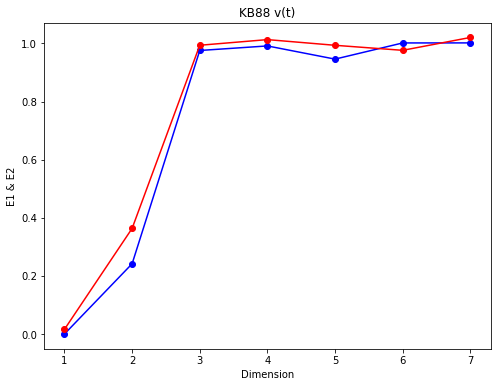

In [36]:
E1, E2 = sp.cao97(timeSeries = multiPeriodic_v[:5000], tau = 162, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('KB88 v(t)')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/multiperiodic_v.png")

### Reproduce Cao 1997 fig 4 (correlated noise)

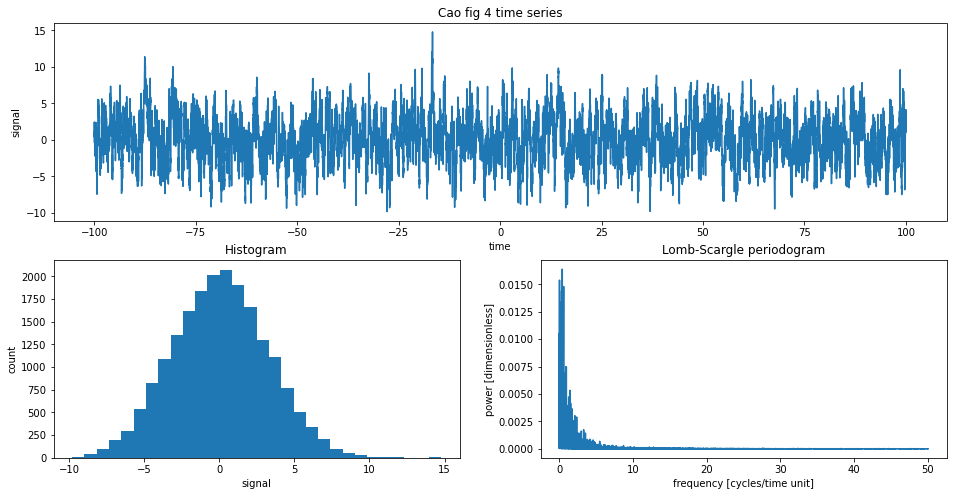

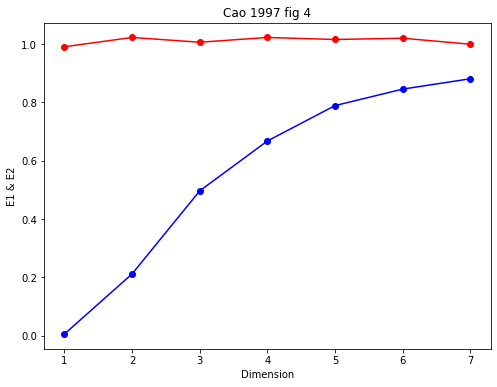

In [37]:
np.random.seed(8421)

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
t = np.arange(tmin,tmax,dt)

gaussianNoise2 = np.random.normal(0.,1.,len(t))

caoFig4 = np.zeros_like(t)
caoFig4[0] = gaussianNoise2[0]
for i in range(1, len(t)):
    caoFig4[i] = caoFig4[i-1]*0.95 + gaussianNoise2[i]
sp.plotTimeSeries(t, caoFig4,min_freq=(1./baseline),max_freq=(1./(2.*dt)),title="Cao fig 4")

# Cao used tau = 1 for this data, because it's a map rather than a continous diff EQ
E1, E2 = sp.cao97(timeSeries = caoFig4[:5000], tau = 1, mMax = 8)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,8),E1,'bo',ls='-')
ax.plot(np.arange(1,8),E2,'ro',ls='-')
ax.set_title('Cao 1997 fig 4')
ax.set_xlabel('Dimension')
ax.set_ylabel('E1 & E2')
#plt.show()
plt.savefig("./plots/cao1997implementation/cao1997fig4.png")

# Calculate correlation integral

### Grassberger & Procaccia 1983

#### They advocate choosing an embedding dimension larger than strictly necessary to reduce error--interesting!

### Start with Kurths & Herzel 1987, actually.

In [13]:

logrArr = np.linspace(-4.,6.,50)
rArr = 2.**logrArr
np.save("./corrDimTesting/rArr.npy", rArr)


In [16]:
"""
start = time.time()
C0_1000_t15_m3, C1_1000_t15_m3, C2_1000_t15_m3, nArr_1000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t15_m3, C1_5000_t15_m3, C2_5000_t15_m3, nArr_5000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t15_m3, C1_10000_t15_m3, C2_10000_t15_m3, nArr_10000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t15_m3, C1_20000_t15_m3, C2_20000_t15_m3, nArr_20000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 15, m = 3)
end = time.time()
print((end-start)/60.)
"""

0.10095853408177693
8.393945968151092


'\nstart = time.time()\nC0_10000_t15_m3, C1_10000_t15_m3, C2_10000_t15_m3, nArr_10000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 15, m = 3)\nend = time.time()\nprint((end-start)/60.)\n\nstart = time.time()\nC0_20000_t15_m3, C1_20000_t15_m3, C2_20000_t15_m3, nArr_20000_t15_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 15, m = 3)\nend = time.time()\nprint((end-start)/60.)\n'

In [17]:
# note: these correspond to r array np.linspace(-4.,6.,50)
"""
np.save("./corrDimTesting/lorenz_x_C0_1000_tau=15_m=3.npy",C0_1000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C1_1000_tau=15_m=3.npy",C1_1000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C2_1000_tau=15_m=3.npy",C2_1000_t15_m3)

np.save("./corrDimTesting/lorenz_x_C0_5000_tau=15_m=3.npy",C0_5000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C1_5000_tau=15_m=3.npy",C1_5000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C2_5000_tau=15_m=3.npy",C2_5000_t15_m3)

np.save("./corrDimTesting/lorenz_x_C0_10000_tau=15_m=3.npy",C0_10000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C1_10000_tau=15_m=3.npy",C1_10000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C2_10000_tau=15_m=3.npy",C2_10000_t15_m3)

np.save("./corrDimTesting/lorenz_x_C0_20000_tau=15_m=3.npy",C0_20000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C1_20000_tau=15_m=3.npy",C1_20000_t15_m3)
np.save("./corrDimTesting/lorenz_x_C2_20000_tau=15_m=3.npy",C2_20000_t15_m3)


# save nArrs
np.save("./corrDimTesting/lorenz_x_nArr_1000_tau=15_m=3.npy",nArr_1000_t15_m3)
np.save("./corrDimTesting/lorenz_x_nArr_5000_tau=15_m=3.npy",nArr_5000_t15_m3)
np.save("./corrDimTesting/lorenz_x_nArr_10000_tau=15_m=3.npy",nArr_10000_t15_m3)
np.save("./corrDimTesting/lorenz_x_nArr_20000_tau=15_m=3.npy",nArr_20000_t15_m3)
"""
# save neighbor distances
#np.save("./corrDimTesting/lorenz_x_nd_1000_tau=15_m=3.npy", nd_1000_t15_m3)
#np.save("./corrDimTesting/lorenz_x_nd_5000_tau=15_m=3.npy", nd_5000_t15_m3)
#np.save("./corrDimTesting/lorenz_x_nd_10000_tau=15_m=3.npy", nd_10000_t15_m3)
#np.save("./corrDimTesting/lorenz_x_nd_20000_tau=15_m=3.npy", nd_20000_t15_m3)


In [18]:
"""
start = time.time()
C0_1000_t60_m3, C1_1000_t60_m3, C2_1000_t60_m3, nArr_1000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t60_m3, C1_5000_t60_m3, C2_5000_t60_m3, nArr_5000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t60_m3, C1_10000_t60_m3, C2_10000_t60_m3, nArr_10000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t60_m3, C1_20000_t60_m3, C2_20000_t60_m3, nArr_20000_t60_m3 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 60, m = 3)
end = time.time()
print((end-start)/60.)
"""

0.10091696580251058
10.356032113234201
86.4727066318194
30.77366496324539


In [19]:
# note: these correspond to r array np.linspace(-4.,6.,50)
"""
np.save("./corrDimTesting/lorenz_x_C0_1000_tau=60_m=3.npy",C0_1000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C1_1000_tau=60_m=3.npy",C1_1000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C2_1000_tau=60_m=3.npy",C2_1000_t60_m3)

np.save("./corrDimTesting/lorenz_x_C0_5000_tau=60_m=3.npy",C0_5000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C1_5000_tau=60_m=3.npy",C1_5000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C2_5000_tau=60_m=3.npy",C2_5000_t60_m3)

np.save("./corrDimTesting/lorenz_x_C0_10000_tau=60_m=3.npy",C0_10000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C1_10000_tau=60_m=3.npy",C1_10000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C2_10000_tau=60_m=3.npy",C2_10000_t60_m3)

np.save("./corrDimTesting/lorenz_x_C0_20000_tau=60_m=3.npy",C0_20000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C1_20000_tau=60_m=3.npy",C1_20000_t60_m3)
np.save("./corrDimTesting/lorenz_x_C2_20000_tau=60_m=3.npy",C2_20000_t60_m3)

#save nArrs
np.save("./corrDimTesting/lorenz_x_nArr_1000_tau=60_m=3.npy",nArr_1000_t60_m3)
np.save("./corrDimTesting/lorenz_x_nArr_5000_tau=60_m=3.npy",nArr_5000_t60_m3)
np.save("./corrDimTesting/lorenz_x_nArr_10000_tau=60_m=3.npy",nArr_10000_t60_m3)
np.save("./corrDimTesting/lorenz_x_nArr_20000_tau=60_m=3.npy",nArr_20000_t60_m3)
"""
# save neighbor distances
#np.save("./corrDimTesting/lorenz_x_nd_1000_tau=60_m=3.npy", nd_1000_t60_m3)
#np.save("./corrDimTesting/lorenz_x_nd_5000_tau=60_m=3.npy", nd_5000_t60_m3)
#np.save("./corrDimTesting/lorenz_x_nd_10000_tau=60_m=3.npy", nd_10000_t60_m3)
#np.save("./corrDimTesting/lorenz_x_nd_20000_tau=60_m=3.npy", nd_20000_t60_m3)


In [20]:
"""
start = time.time()
C0_1000_t15_m4, C1_1000_t15_m4, C2_1000_t15_m4, nArr_1000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t15_m4, C1_5000_t15_m4, C2_5000_t15_m4, nArr_5000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t15_m4, C1_10000_t15_m4, C2_10000_t15_m4, nArr_10000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t15_m4, C1_20000_t15_m4, C2_20000_t15_m4, nArr_20000_t15_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 15, m = 4)
end = time.time()
print((end-start)/60.)
"""

0.092903204758962
9.631280732154845
90.11337380011877
36.23072103261948


In [21]:
# note: these correspond to r array np.linspace(-4.,6.,50)
"""
np.save("./corrDimTesting/lorenz_x_C0_1000_tau=15_m=4.npy",C0_1000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C1_1000_tau=15_m=4.npy",C1_1000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C2_1000_tau=15_m=4.npy",C2_1000_t15_m4)

np.save("./corrDimTesting/lorenz_x_C0_5000_tau=15_m=4.npy",C0_5000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C1_5000_tau=15_m=4.npy",C1_5000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C2_5000_tau=15_m=4.npy",C2_5000_t15_m4)

np.save("./corrDimTesting/lorenz_x_C0_10000_tau=15_m=4.npy",C0_10000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C1_10000_tau=15_m=4.npy",C1_10000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C2_10000_tau=15_m=4.npy",C2_10000_t15_m4)

np.save("./corrDimTesting/lorenz_x_C0_20000_tau=15_m=4.npy",C0_20000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C1_20000_tau=15_m=4.npy",C1_20000_t15_m4)
np.save("./corrDimTesting/lorenz_x_C2_20000_tau=15_m=4.npy",C2_20000_t15_m4)

#save nArrs
np.save("./corrDimTesting/lorenz_x_nArr_1000_tau=15_m=4.npy",nArr_1000_t15_m4)
np.save("./corrDimTesting/lorenz_x_nArr_5000_tau=15_m=4.npy",nArr_5000_t15_m4)
np.save("./corrDimTesting/lorenz_x_nArr_10000_tau=15_m=4.npy",nArr_10000_t15_m4)
np.save("./corrDimTesting/lorenz_x_nArr_20000_tau=15_m=4.npy",nArr_20000_t15_m4)
"""

# save neighbor distances
#np.save("./corrDimTesting/lorenz_x_nd_1000_tau=15_m=4.npy", nd_1000_t15_m4)
#np.save("./corrDimTesting/lorenz_x_nd_5000_tau=15_m=4.npy", nd_5000_t15_m4)
#np.save("./corrDimTesting/lorenz_x_nd_10000_tau=15_m=4.npy", nd_10000_t15_m4)
#np.save("./corrDimTesting/lorenz_x_nd_20000_tau=15_m=4.npy", nd_20000_t15_m4)


In [22]:
"""
start = time.time()
C0_1000_t60_m4, C1_1000_t60_m4, C2_1000_t60_m4, nArr_1000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:1000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_5000_t60_m4, C1_5000_t60_m4, C2_5000_t60_m4, nArr_5000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:5000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_10000_t60_m4, C1_10000_t60_m4, C2_10000_t60_m4, nArr_10000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:10000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)

start = time.time()
C0_20000_t60_m4, C1_20000_t60_m4, C2_20000_t60_m4, nArr_20000_t60_m4 = sp.Cq(rArr=rArr, timeSeries=lorenz_r[:20000,0], tau = 60, m = 4)
end = time.time()
print((end-start)/60.)
"""

0.06623845100402832
8.53641718228658
94.11191350221634
51.644079101085666


In [23]:
# note: these correspond to r array np.linspace(-3.5,5.8,50)
"""
np.save("./corrDimTesting/lorenz_x_C0_1000_tau=60_m=4.npy",C0_1000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C1_1000_tau=60_m=4.npy",C1_1000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C2_1000_tau=60_m=4.npy",C2_1000_t60_m4)

np.save("./corrDimTesting/lorenz_x_C0_5000_tau=60_m=4.npy",C0_5000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C1_5000_tau=60_m=4.npy",C1_5000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C2_5000_tau=60_m=4.npy",C2_5000_t60_m4)

np.save("./corrDimTesting/lorenz_x_C0_10000_tau=60_m=4.npy",C0_10000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C1_10000_tau=60_m=4.npy",C1_10000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C2_10000_tau=60_m=4.npy",C2_10000_t60_m4)

np.save("./corrDimTesting/lorenz_x_C0_20000_tau=60_m=4.npy",C0_20000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C1_20000_tau=60_m=4.npy",C1_20000_t60_m4)
np.save("./corrDimTesting/lorenz_x_C2_20000_tau=60_m=4.npy",C2_20000_t60_m4)

#save nArrs
np.save("./corrDimTesting/lorenz_x_nArr_1000_tau=60_m=4.npy",nArr_1000_t60_m4)
np.save("./corrDimTesting/lorenz_x_nArr_5000_tau=60_m=4.npy",nArr_5000_t60_m4)
np.save("./corrDimTesting/lorenz_x_nArr_10000_tau=60_m=4.npy",nArr_10000_t60_m4)
np.save("./corrDimTesting/lorenz_x_nArr_20000_tau=60_m=4.npy",nArr_20000_t60_m4)
"""

# save neighbor distances
#np.save("./corrDimTesting/lorenz_x_nd_1000_tau=60_m=4.npy", nd_1000_t60_m4)
#np.save("./corrDimTesting/lorenz_x_nd_5000_tau=60_m=4.npy", nd_5000_t60_m4)
#np.save("./corrDimTesting/lorenz_x_nd_10000_tau=60_m=4.npy", nd_10000_t60_m4)
#np.save("./corrDimTesting/lorenz_x_nd_20000_tau=60_m=4.npy", nd_20000_t60_m4)


In [53]:
rArr = np.load("./corrDimTesting/rArr.npy")
C0_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C0_1000_tau=15_m=3.npy")
C0_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C0_5000_tau=15_m=3.npy")
C0_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C0_10000_tau=15_m=3.npy")
C0_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C0_20000_tau=15_m=3.npy")

C0_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C0_1000_tau=60_m=3.npy")
C0_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C0_5000_tau=60_m=3.npy")
C0_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C0_10000_tau=60_m=3.npy")
C0_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C0_20000_tau=60_m=3.npy")

C0_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C0_1000_tau=15_m=4.npy")
C0_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C0_5000_tau=15_m=4.npy")
C0_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C0_10000_tau=15_m=4.npy")
C0_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C0_20000_tau=15_m=4.npy")

C0_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C0_1000_tau=60_m=4.npy")
C0_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C0_5000_tau=60_m=4.npy")
C0_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C0_10000_tau=60_m=4.npy")
C0_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C0_20000_tau=60_m=4.npy")

C1_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C1_1000_tau=15_m=3.npy")
C1_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C1_5000_tau=15_m=3.npy")
C1_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C1_10000_tau=15_m=3.npy")
C1_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C1_20000_tau=15_m=3.npy")

C1_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C1_1000_tau=60_m=3.npy")
C1_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C1_5000_tau=60_m=3.npy")
C1_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C1_10000_tau=60_m=3.npy")
C1_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C1_20000_tau=60_m=3.npy")

C1_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C1_1000_tau=15_m=4.npy")
C1_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C1_5000_tau=15_m=4.npy")
C1_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C1_10000_tau=15_m=4.npy")
C1_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C1_20000_tau=15_m=4.npy")

C1_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C1_1000_tau=60_m=4.npy")
C1_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C1_5000_tau=60_m=4.npy")
C1_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C1_10000_tau=60_m=4.npy")
C1_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C1_20000_tau=60_m=4.npy")

C2_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C2_1000_tau=15_m=3.npy")
C2_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C2_5000_tau=15_m=3.npy")
C2_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C2_10000_tau=15_m=3.npy")
C2_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_C2_20000_tau=15_m=3.npy")

C2_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C2_1000_tau=60_m=3.npy")
C2_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C2_5000_tau=60_m=3.npy")
C2_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C2_10000_tau=60_m=3.npy")
C2_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_C2_20000_tau=60_m=3.npy")

C2_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C2_1000_tau=15_m=4.npy")
C2_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C2_5000_tau=15_m=4.npy")
C2_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C2_10000_tau=15_m=4.npy")
C2_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_C2_20000_tau=15_m=4.npy")

C2_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C2_1000_tau=60_m=4.npy")
C2_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C2_5000_tau=60_m=4.npy")
C2_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C2_10000_tau=60_m=4.npy")
C2_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_C2_20000_tau=60_m=4.npy")


#nd_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nd_1000_tau=15_m=3.npy")
#nd_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nd_5000_tau=15_m=3.npy")
#nd_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nd_10000_tau=15_m=3.npy")
#nd_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nd_20000_tau=15_m=3.npy")

#nd_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nd_1000_tau=60_m=3.npy")
#nd_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nd_5000_tau=60_m=3.npy")
#nd_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nd_10000_tau=60_m=3.npy")
#nd_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nd_20000_tau=60_m=3.npy")

#nd_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nd_1000_tau=15_m=4.npy")
#nd_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nd_5000_tau=15_m=4.npy")
#nd_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nd_10000_tau=15_m=4.npy")
#nd_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nd_20000_tau=15_m=4.npy")

#nd_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nd_1000_tau=60_m=4.npy")
#nd_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nd_5000_tau=60_m=4.npy")
#nd_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nd_10000_tau=60_m=4.npy")
#nd_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nd_20000_tau=60_m=4.npy")

nArr_1000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nArr_1000_tau=15_m=3.npy")
nArr_5000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nArr_5000_tau=15_m=3.npy")
nArr_10000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nArr_10000_tau=15_m=3.npy")
nArr_20000_t15_m3 = np.load("./corrDimTesting/lorenz_x_nArr_20000_tau=15_m=3.npy")

nArr_1000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nArr_1000_tau=60_m=3.npy")
nArr_5000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nArr_5000_tau=60_m=3.npy")
nArr_10000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nArr_10000_tau=60_m=3.npy")
nArr_20000_t60_m3 = np.load("./corrDimTesting/lorenz_x_nArr_20000_tau=60_m=3.npy")

nArr_1000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nArr_1000_tau=15_m=4.npy")
nArr_5000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nArr_5000_tau=15_m=4.npy")
nArr_10000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nArr_10000_tau=15_m=4.npy")
nArr_20000_t15_m4 = np.load("./corrDimTesting/lorenz_x_nArr_20000_tau=15_m=4.npy")

nArr_1000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nArr_1000_tau=60_m=4.npy")
nArr_5000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nArr_5000_tau=60_m=4.npy")
nArr_10000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nArr_10000_tau=60_m=4.npy")
nArr_20000_t60_m4 = np.load("./corrDimTesting/lorenz_x_nArr_20000_tau=60_m=4.npy")

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:138: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarn

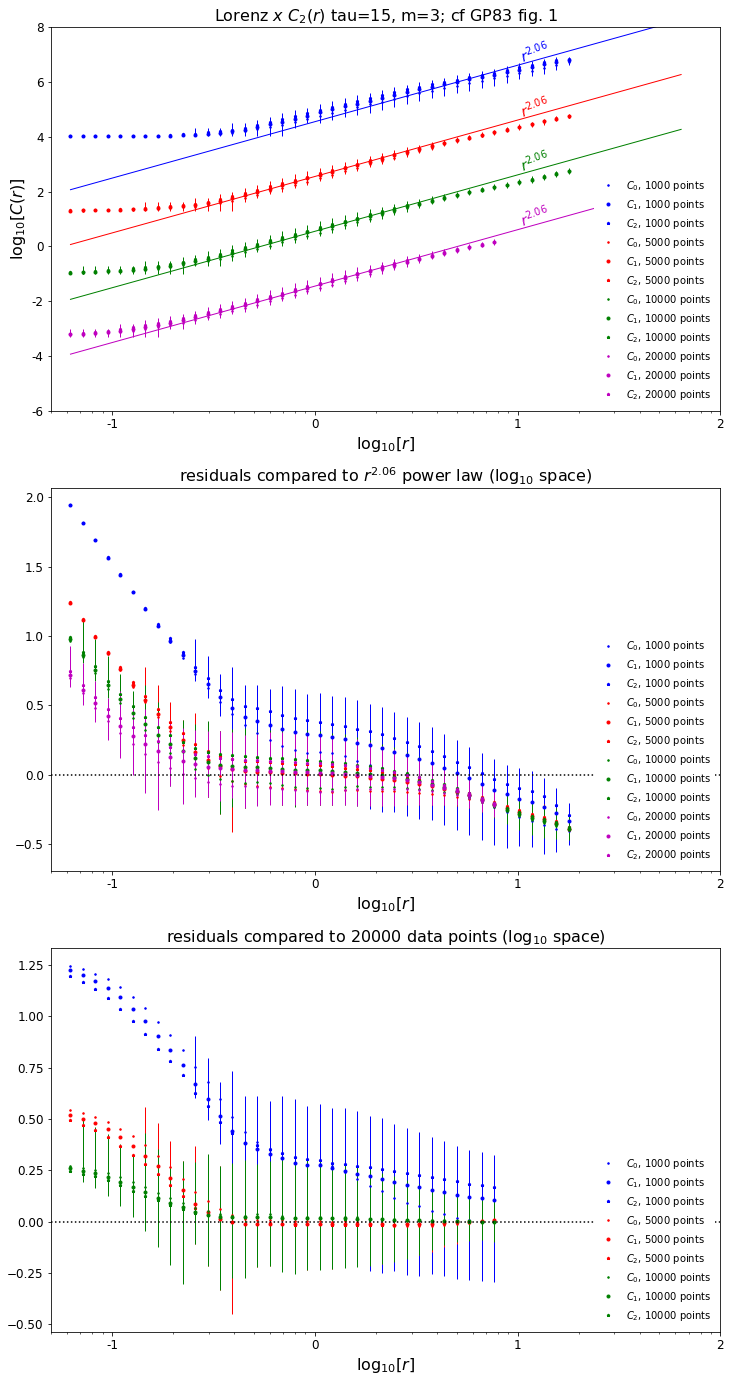

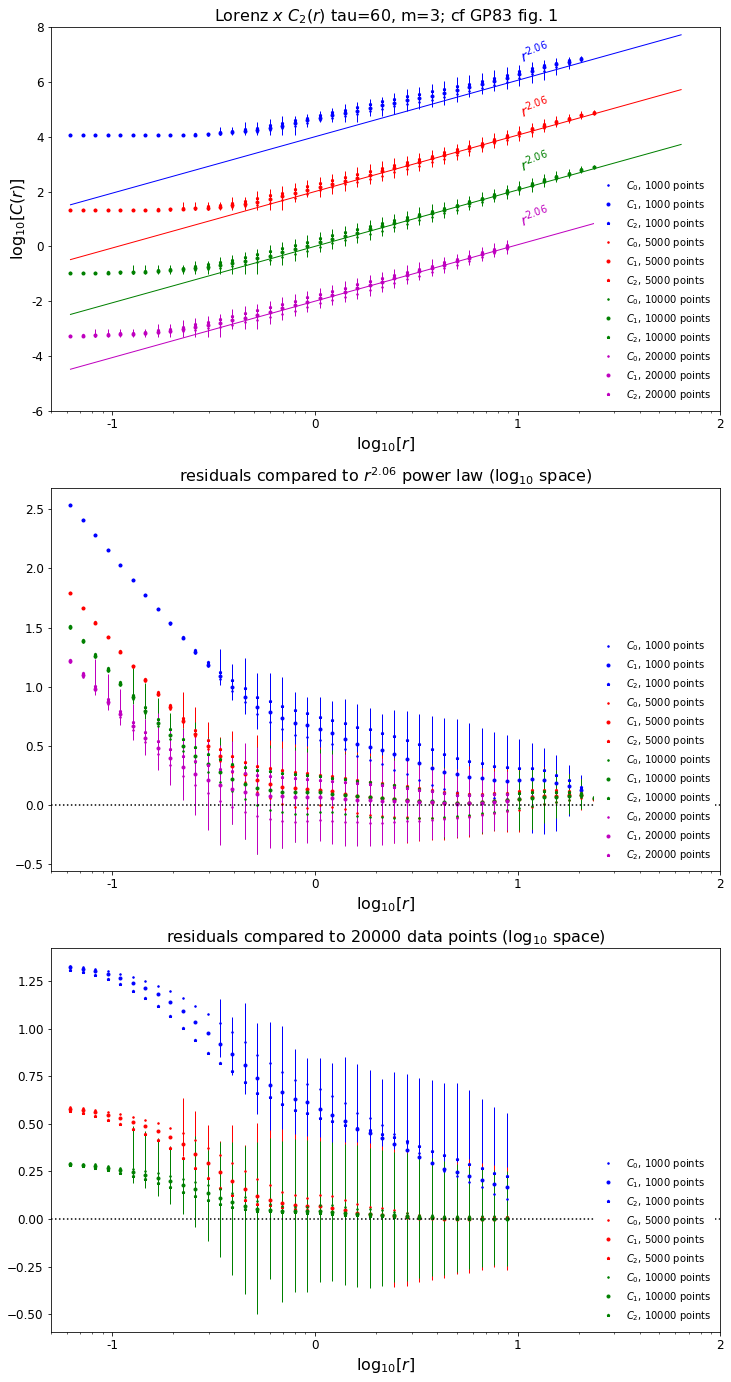

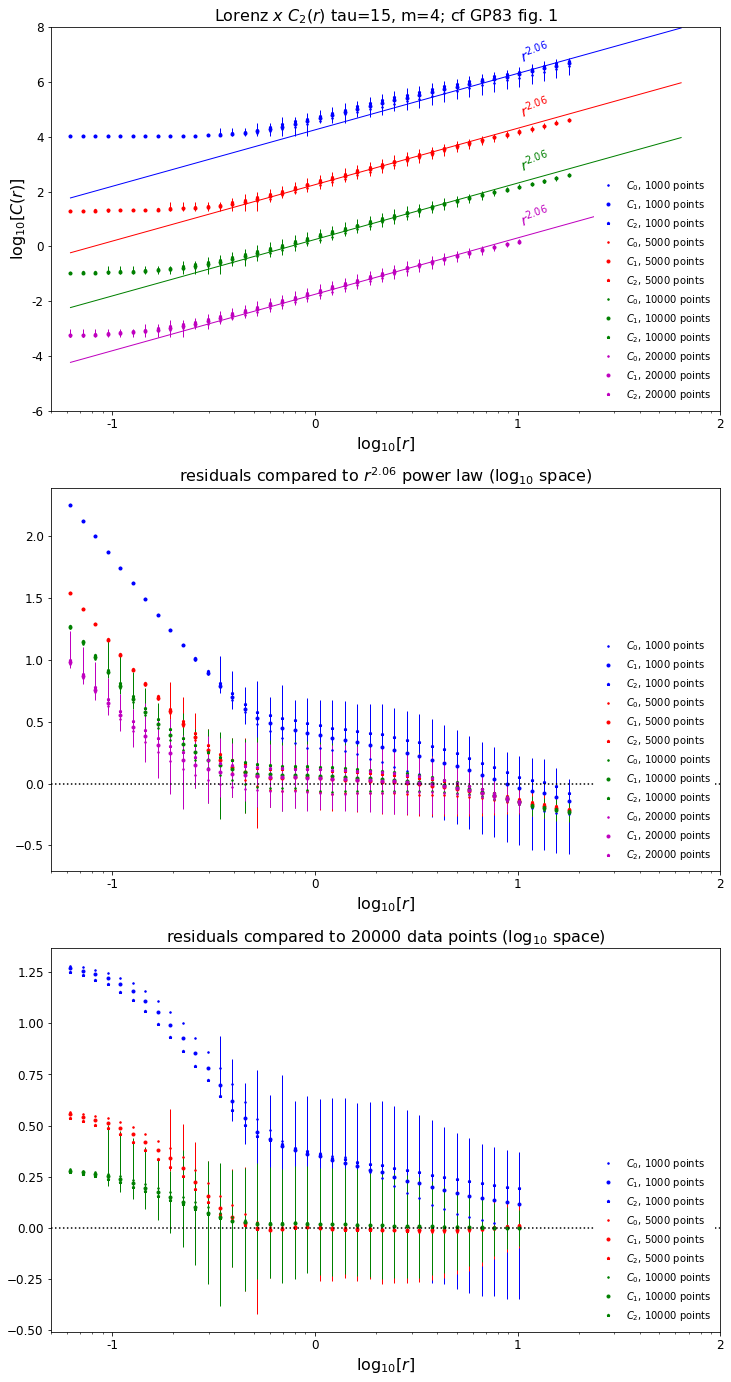

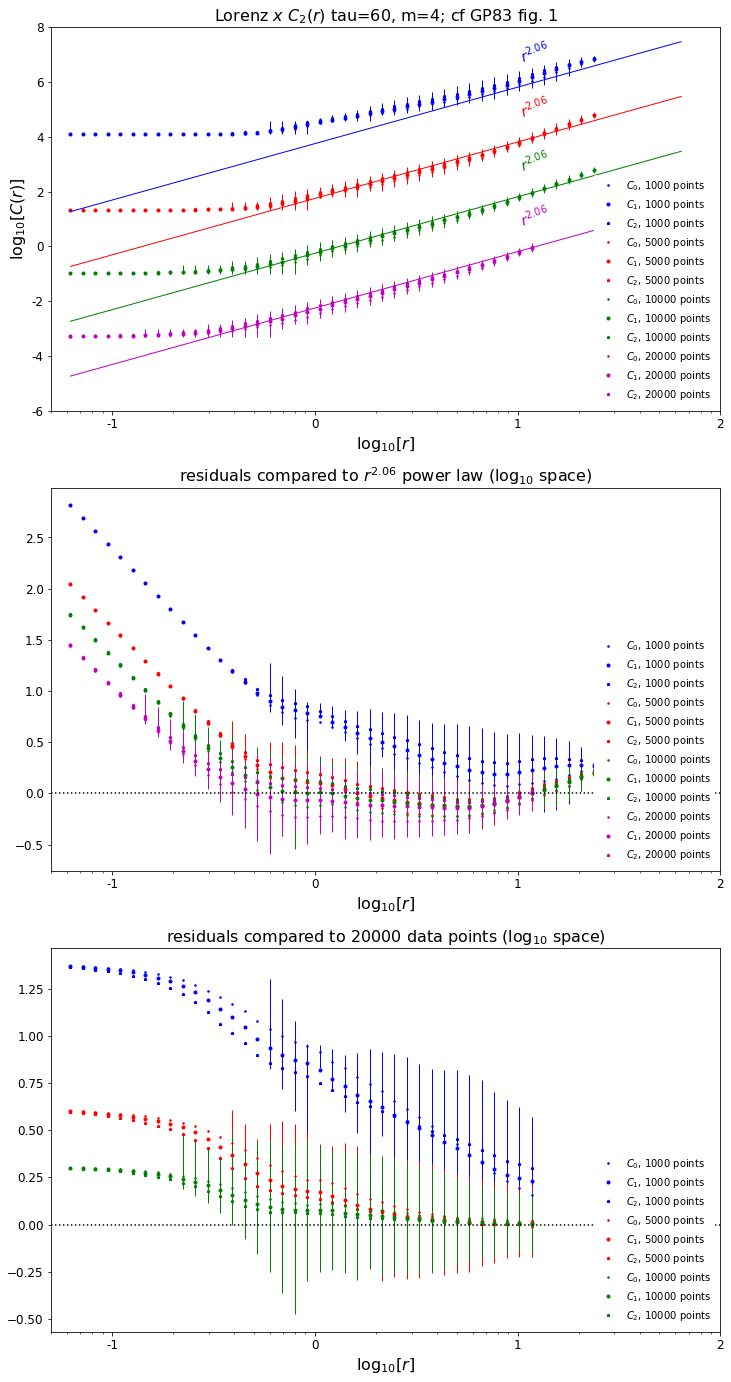

In [207]:
combos = [(15,3),(60,3),(15,4),(60,4)]
C0_1000 = [C0_1000_t15_m3, C0_1000_t60_m3, C0_1000_t15_m4, C0_1000_t60_m4]
C1_1000 = [C1_1000_t15_m3, C1_1000_t60_m3, C1_1000_t15_m4, C1_1000_t60_m4]
C2_1000 = [C2_1000_t15_m3, C2_1000_t60_m3, C2_1000_t15_m4, C2_1000_t60_m4]
n_1000 = [nArr_1000_t15_m3, nArr_1000_t60_m3, nArr_1000_t15_m4, nArr_1000_t60_m4]

C0_5000 = [C0_5000_t15_m3, C0_5000_t60_m3, C0_5000_t15_m4, C0_5000_t60_m4]
C1_5000 = [C1_5000_t15_m3, C1_5000_t60_m3, C1_5000_t15_m4, C1_5000_t60_m4]
C2_5000 = [C2_5000_t15_m3, C2_5000_t60_m3, C2_5000_t15_m4, C2_5000_t60_m4]
n_5000 = [nArr_5000_t15_m3, nArr_5000_t60_m3, nArr_5000_t15_m4, nArr_5000_t60_m4]

C0_10000 = [C0_10000_t15_m3, C0_10000_t60_m3, C0_10000_t15_m4, C0_10000_t60_m4]
C1_10000 = [C1_10000_t15_m3, C1_10000_t60_m3, C1_10000_t15_m4, C1_10000_t60_m4]
C2_10000 = [C2_10000_t15_m3, C2_10000_t60_m3, C2_10000_t15_m4, C2_10000_t60_m4]
n_10000 = [nArr_10000_t15_m3, nArr_10000_t60_m3, nArr_10000_t15_m4, nArr_10000_t60_m4]

C0_20000 = [C0_20000_t15_m3, C0_20000_t60_m3, C0_20000_t15_m4, C0_20000_t60_m4]
C1_20000 = [C1_20000_t15_m3, C1_20000_t60_m3, C1_20000_t15_m4, C1_20000_t60_m4]
C2_20000 = [C2_20000_t15_m3, C2_20000_t60_m3, C2_20000_t15_m4, C2_20000_t60_m4]
n_20000 = [nArr_20000_t15_m3, nArr_20000_t60_m3, nArr_20000_t15_m4, nArr_20000_t60_m4]

# vertical offsets for the different-length time series
vOffset = [10**7, 10**5, 10**3, 10**1]

# adjustments to vertical offsets for the different choices of tau and m
bOffset = [10**-2.45,10**-3,10**-2.75,10**-3.25]
Narr = [(970,4970,9970,19970),(880,4880,9880,19880),(955,4995,9955,19955),(820,4820,9820,19820)]


for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    
    p84_1000 = np.percentile(n_1000[i], 84, axis=0)
    p50_1000 = np.percentile(n_1000[i], 50, axis=0)
    p16_1000 = np.percentile(n_1000[i], 16, axis=0)
    
    p84_5000 = np.percentile(n_5000[i], 84, axis=0)
    p50_5000 = np.percentile(n_5000[i], 50, axis=0)
    p16_5000 = np.percentile(n_5000[i], 16, axis=0)
    
    p84_10000 = np.percentile(n_10000[i], 84, axis=0)
    p50_10000 = np.percentile(n_10000[i], 50, axis=0)
    p16_10000 = np.percentile(n_10000[i], 16, axis=0)
    
    p84_20000 = np.percentile(n_20000[i], 84, axis=0)
    p50_20000 = np.percentile(n_20000[i], 50, axis=0)
    p16_20000 = np.percentile(n_20000[i], 16, axis=0)
    
    fig, axes = plt.subplots(3,1,figsize=(12,24))
    
    axes[0].plot(rArr,C0_1000[i] * vOffset[0],color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")    
    axes[0].plot(rArr,C1_1000[i] * vOffset[0],color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[0].plot(rArr,C2_1000[i] * vOffset[0],color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[0].vlines(x=rArr, ymin=p16_1000 * vOffset[0], ymax=p84_1000 * vOffset[0], color='b',lw=1)
    
    axes[0].plot(rArr,C0_5000[i] * vOffset[1],color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[0].plot(rArr,C1_5000[i] * vOffset[1],color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[0].plot(rArr,C2_5000[i] * vOffset[1],color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[0].vlines(x=rArr, ymin=p16_5000 * vOffset[1], ymax=p84_5000 * vOffset[1], color='r',lw=1)
    
    axes[0].plot(rArr,C0_10000[i]* vOffset[2],color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[0].plot(rArr,C1_10000[i]* vOffset[2],color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[0].plot(rArr,C2_10000[i]* vOffset[2],color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[0].vlines(x=rArr, ymin=p16_10000 * vOffset[2], ymax=p84_10000 * vOffset[2], color='g',lw=1)
    
    axes[0].plot(rArr,C0_20000[i]* vOffset[3],color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[0].plot(rArr,C1_20000[i]* vOffset[3],color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[0].plot(rArr,C2_20000[i]* vOffset[3],color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[0].vlines(x=rArr, ymin=p16_20000 * vOffset[3], ymax=p84_20000 * vOffset[3], color='m',lw=1)
    
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[0],'b-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[1],'r-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[2],'g-',lw=1)
    axes[0].plot(rArr,(rArr**2.06) * bOffset[i] * vOffset[3],'m-',lw=1)

    axes[0].text(10.,vOffset[0]*0.5,r"$r^{2.06}$",color='b',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[1]*0.5,r"$r^{2.06}$",color='r',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[2]*0.5,r"$r^{2.06}$",color='g',fontsize=14,rotation=20)
    axes[0].text(10.,vOffset[3]*0.5,r"$r^{2.06}$",color='m',fontsize=14,rotation=20)
    
    axes[0].set_ylabel(r"$\log_{10}[C(r)]$", fontsize=16)
    axes[0].set_title(r"Lorenz $x$ $C_2(r)$ tau={0}, m={1}; cf GP83 fig. 1".format(t,m),fontsize=16)
    axes[0].set_yscale("log")
    axes[0].set_ylim(1.e-6,1.e8)
    axes[0].set_yticklabels([-8,-6,-4,-2,0,2,4,6,8])
    
    # residuals compared to power law
    axes[1].plot(rArr,np.log10(C0_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[1].plot(rArr,np.log10(C1_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[1].plot(rArr,np.log10(C2_1000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_1000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='b',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[1].plot(rArr,np.log10(C1_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[1].plot(rArr,np.log10(C2_5000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_5000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='r',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[1].plot(rArr,np.log10(C1_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[1].plot(rArr,np.log10(C2_10000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_10000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='g',lw=1.,alpha=1)
    
    axes[1].plot(rArr,np.log10(C0_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 20000 points")
    axes[1].plot(rArr,np.log10(C1_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 20000 points")
    axes[1].plot(rArr,np.log10(C2_20000[i]) - np.log10(rArr**2.06) - np.log10(bOffset[i]),color='m',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 20000 points")
    axes[1].vlines(x=rArr, ymin=np.log10(p16_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), ymax=np.log10(p84_20000)-np.log10(rArr**2.06) - np.log10(bOffset[i]), color='m',lw=1.,alpha=1)
    
    axes[1].axhline(0,color='k',ls=':')
    axes[1].set_title(r"residuals compared to $r^{2.06}$ power law ($\log_{10}$ space)",fontsize=16)
    
    # residuals compared to 20000 data points
    axes[2].plot(rArr,np.log10(C0_1000[i]) - np.log10(C0_20000[i]),color='b',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 1000 points")
    axes[2].plot(rArr,np.log10(C1_1000[i]) - np.log10(C1_20000[i]),color='b',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 1000 points")
    axes[2].plot(rArr,np.log10(C2_1000[i]) - np.log10(C2_20000[i]),color='b',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 1000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_1000)-np.log10(C1_20000[i]), ymax=np.log10(p84_1000)-np.log10(C1_20000[i]), color='b',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_5000[i]) - np.log10(C0_20000[i]),color='r',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 5000 points")
    axes[2].plot(rArr,np.log10(C1_5000[i]) - np.log10(C1_20000[i]),color='r',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 5000 points")
    axes[2].plot(rArr,np.log10(C2_5000[i]) - np.log10(C2_20000[i]),color='r',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 5000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_5000)-np.log10(C1_20000[i]), ymax=np.log10(p84_5000)-np.log10(C1_20000[i]), color='r',lw=1.,alpha=1)
    
    axes[2].plot(rArr,np.log10(C0_10000[i]) - np.log10(C0_20000[i]),color='g',marker='.',ls="None",lw=0.5,ms=3,label=r"$C_0$, 10000 points")
    axes[2].plot(rArr,np.log10(C1_10000[i]) - np.log10(C1_20000[i]),color='g',marker='o',ls="None",lw=0.5,ms=3,label=r"$C_1$, 10000 points")
    axes[2].plot(rArr,np.log10(C2_10000[i]) - np.log10(C2_20000[i]),color='g',marker='*',ls="None",lw=0.5,ms=3,label=r"$C_2$, 10000 points")
    axes[2].vlines(x=rArr, ymin=np.log10(p16_10000)-np.log10(C1_20000[i]), ymax=np.log10(p84_10000)-np.log10(C1_20000[i]), color='g',lw=1.,alpha=1)
    
    axes[2].axhline(0,color='k',ls=':')
    axes[2].set_title(r"residuals compared to 20000 data points ($\log_{10}$ space)",fontsize=16)
    

    for ax in axes:
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xlabel(r"$\log_{10}[r]$", fontsize=16)
        ax.set_xscale("log")
        ax.set_xlim(5.e-2,1.e2)
        ax.set_xticklabels([-3,-2,-1,0,1,2])
        ax.legend(loc="lower right",frameon=True,framealpha=1.0, edgecolor='None')
    
    #plt.show()
    plt.savefig("./plots/gp1983implementation/lorenz_x_timeSeriesLength_tau={0}_m={1}.pdf".format(t,m))
    

In [208]:
def normal_equation(x, y, yerr, order=2):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    x = matrix of x values
    y = vector of y values
    yerr = vector of yerr values
    order = integer polynomial order 
    
    Outputs:
    b = vector of model parameters that minimizes chi^2
    Bunc = covariance matrix of uncertainties on model parameters. diagonal entries are sigma**2 of the individual parameters, and off-diagonals are covariances.
    """
    
    X = np.vander(x, order)
    
    XTX = np.dot(X.T, X/yerr[:, None]**2)
    
    b = np.linalg.solve(XTX, np.dot(X.T, y/yerr**2))
    Bunc = np.linalg.solve(XTX, np.identity(order))
    return b, Bunc

In [209]:
x = np.arange(10)
y = 3.*x + 5 + np.random.normal(0.,0.5,size=len(x))

b,Bunc = normal_equation(x, y, 0.5*np.ones_like(y), 2)
print(b)
print(Bunc)

[3.0699852  4.96111065]
[[ 0.0030303  -0.01363636]
 [-0.01363636  0.08636364]]


In [210]:
# fit line to linear regime of data only
def fitLinearRegime(rArr, nArr, C):
    N = len(nArr[:,0])
    medians = np.percentile(nArr, 50, axis=0)
    
    # uncertainty on C at each value of r will be defined as the 84th-50th percentile or the 50th-16th percentile, whichever is larger
    Cunc_up = np.percentile(nArr, 84, axis=0) - np.percentile(nArr, 50, axis=0)
    Cunc_down =  np.percentile(nArr, 50, axis=0) - np.percentile(nArr, 16, axis=0)
    
    #element-wise maximum
    Cunc = np.maximum(Cunc_down,Cunc_up)
    
    # transform variables to get uncertainty in log10 space
    Cunc_log10 = (Cunc/(np.log(10) * C))
    
    # exclude values of r where the median of n(r) is <= 10./N . Cutoff is a little arbitrary but the idea is that these points don't have enough neighbors.
    enoughNeighborsIdxs = np.arange(len(rArr))[medians > 10./N]
    firstGood = enoughNeighborsIdxs[0]
    
    # exclude values of r where any n(r) are NaN. The time series is not long enough to populate all the neighbors of the points.
    anyNans = [np.any(~np.isfinite(nArr[:,i])) for i in range(len(rArr))]
    anyNans = np.array(anyNans)
    nansIdxs = np.arange(len(rArr))[anyNans]
    lastGood = nansIdxs[0]
    
    """
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    axes[0].errorbar(rArr[firstGood:lastGood], C[firstGood:lastGood], Cunc[firstGood:lastGood])
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    
    axes[1].errorbar(np.log10(rArr[firstGood:lastGood]), np.log10(C[firstGood:lastGood]), Cunc_log10[firstGood:lastGood])
    
    axes[0].set_xlim(10**-1.5, 10**1.5)
    axes[1].set_xlim(-1.5,1.5)
    axes[0].set_ylim(10**-4, 10**0)
    axes[1].set_ylim(-4,0)

    plt.show()
    """
    
    params, params_unc = normal_equation(x=np.log10(rArr)[firstGood:lastGood], y=np.log10(C)[firstGood:lastGood], yerr=Cunc_log10[firstGood:lastGood], order=2)
    return params, params_unc


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


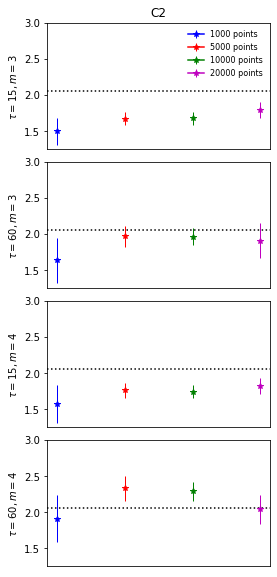

In [235]:
fig, axes = plt.subplots(4,1,figsize=(4,10))#plt.subplots(4,3,figsize=(8,8))

for i, combo in enumerate(combos):
    t = combo[0]
    m = combo[1]
    """
    params_1000_C0, params_unc_1000_C0 = fitLinearRegime(rArr, n_1000[i], C0_1000[i])
    params_5000_C0, params_unc_5000_C0 = fitLinearRegime(rArr, n_5000[i], C0_5000[i])
    params_10000_C0, params_unc_10000_C0 = fitLinearRegime(rArr, n_10000[i], C0_10000[i])
    params_20000_C0, params_unc_20000_C0 = fitLinearRegime(rArr, n_20000[i], C0_20000[i])
    
    params_1000_C1, params_unc_1000_C1 = fitLinearRegime(rArr, n_1000[i], C1_1000[i])
    params_5000_C1, params_unc_5000_C1 = fitLinearRegime(rArr, n_5000[i], C1_5000[i])
    params_10000_C1, params_unc_10000_C1 = fitLinearRegime(rArr, n_10000[i], C1_10000[i])
    params_20000_C1, params_unc_20000_C1 = fitLinearRegime(rArr, n_20000[i], C1_20000[i])
    """
    params_1000_C2, params_unc_1000_C2 = fitLinearRegime(rArr, n_1000[i], C2_1000[i])
    params_5000_C2, params_unc_5000_C2 = fitLinearRegime(rArr, n_5000[i], C2_5000[i])
    params_10000_C2, params_unc_10000_C2 = fitLinearRegime(rArr, n_10000[i], C2_10000[i])
    params_20000_C2, params_unc_20000_C2 = fitLinearRegime(rArr, n_20000[i], C2_20000[i])
    """
    axes[i,0].axhline(2.06,color='k',linestyle=":")
    axes[i,0].errorbar(1, params_1000_C0[0], np.sqrt(params_unc_1000_C0[0,0]), marker='.', color='b', elinewidth=1,label='1000 points')
    axes[i,0].errorbar(2, params_5000_C0[0], np.sqrt(params_unc_5000_C0[0,0]), marker='.', color='r', elinewidth=1, label='5000 points')
    axes[i,0].errorbar(3, params_10000_C0[0], np.sqrt(params_unc_10000_C0[0,0]), marker='.', color='g', elinewidth=1, label='10000 points')
    axes[i,0].errorbar(4, params_20000_C0[0], np.sqrt(params_unc_20000_C0[0,0]), marker='.', color='m', elinewidth=1, label='20000 points')
    axes[i,0].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i,0].set_xticks([])
    axes[i,0].set_ylim(1.25,3)
    
    axes[i,1].axhline(2.06,color='k',linestyle=":")
    axes[i,1].errorbar(1, params_1000_C1[0], np.sqrt(params_unc_1000_C1[0,0]), marker='o', color='b', elinewidth=1,label='1000 points')
    axes[i,1].errorbar(2, params_5000_C1[0], np.sqrt(params_unc_5000_C1[0,0]), marker='o', color='r', elinewidth=1, label='5000 points')
    axes[i,1].errorbar(3, params_10000_C1[0], np.sqrt(params_unc_10000_C1[0,0]), marker='o', color='g', elinewidth=1, label='10000 points')
    axes[i,1].errorbar(4, params_20000_C1[0], np.sqrt(params_unc_20000_C1[0,0]), marker='o', color='m', elinewidth=1, label='20000 points')
    axes[i,1].set_xticks([])
    axes[i,1].set_ylim(1.25,3)
    """
    axes[i].axhline(2.06,color='k',linestyle=":")
    axes[i].errorbar(1, params_1000_C2[0], np.sqrt(params_unc_1000_C2[0,0]), marker='*', color='b', elinewidth=1,label='1000 points')
    axes[i].errorbar(2, params_5000_C2[0], np.sqrt(params_unc_5000_C2[0,0]), marker='*', color='r', elinewidth=1, label='5000 points')
    axes[i].errorbar(3, params_10000_C2[0], np.sqrt(params_unc_10000_C2[0,0]), marker='*', color='g', elinewidth=1, label='10000 points')
    axes[i].errorbar(4, params_20000_C2[0], np.sqrt(params_unc_20000_C2[0,0]), marker='*', color='m', elinewidth=1, label='20000 points')
    axes[i].set_xticks([])
    axes[i].set_ylabel(r"$\tau = {0}, m = {1}$ ".format(t,m))
    axes[i].set_ylim(1.25,3)
    
axes[0].legend(fontsize=8,loc='upper right', frameon=False)

#axes[0,0].set_title("C0")
#axes[0,1].set_title("C1")
axes[0].set_title("C2")
plt.subplots_adjust(hspace=0.1,wspace=0.4)
#plt.show()
plt.savefig("./plots/gp1983implementation/lorenz_x_recoveredPowerLawSlope.pdf")
    